In [1]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import numpy as np 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from pandas.plotting import boxplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
print(__doc__)



Automatically created module for IPython interactive environment


Helper Function for plotting learning curves

In [2]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve
#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py
#https://scikit-learn.org/stable/modules/model_evaluation.html



def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()

    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [3]:
raw_data_url = 'https://raw.githubusercontent.com/andrewmejia600/MSDS7331/master/RAW_DATA/95_cleaned_Raw_Data.csv'

In [4]:
ml_data = pd.read_csv(raw_data_url)

In [5]:
ml_data.head(n=5)

age         workclass  fnlwght  education  education_num_yr  \
0   39         State-gov    77516  Bachelors                13   
1   50  Self-emp-not-inc    83311  Bachelors                13   
2   38           Private   215646    HS-grad                 9   
3   53           Private   234721       11th                 7   
4   28           Private   338409  Bachelors                13   

       marital_status         occupation   relationship   race     sex  ...  \
0       Never-married       Adm-clerical  Not-in-family  White    Male  ...   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male  ...   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male  ...   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male  ...   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female  ...   

   annual_income  origin_descent  origin_descent_us income_outcome  \
0          <=50K   United States                  1              0   
1          <=50K   United States                  1              0   
2          <=50K   United States                  1              0   
3          <=50K   United States                  1              0   
4          <=50K           Carib                  0              0   

  level_of_employ age_range  education_level  marital_stat age_range_ord  \
0              FT     adult            CGRAD     Unmarried             2   
1              PT     adult            CGRAD       Married             2   
2              FT     adult           HSGRAD     Unmarried             2   
3              FT     adult               HS       Married             2   
4              FT     adult            CGRAD       Married             2   

  education_level_ord  
0                   6  
1                   6  
2                   3  
3                   2  
4                   6  

[5 rows x 24 columns]

In [6]:
ml_data.dtypes

age                     int64
workclass              object
fnlwght                 int64
education              object
education_num_yr        int64
marital_status         object
occupation             object
relationship           object
race                   object
sex                    object
cap_gain                int64
cap_loss                int64
hours_per_week          int64
native_country         object
annual_income          object
origin_descent         object
origin_descent_us       int64
income_outcome          int64
level_of_employ        object
age_range              object
education_level        object
marital_stat           object
age_range_ord           int64
education_level_ord     int64
dtype: object

In [7]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  30072 non-null  int64 
 1   workclass            30072 non-null  object
 2   fnlwght              30072 non-null  int64 
 3   education            30072 non-null  object
 4   education_num_yr     30072 non-null  int64 
 5   marital_status       30072 non-null  object
 6   occupation           30072 non-null  object
 7   relationship         30072 non-null  object
 8   race                 30072 non-null  object
 9   sex                  30072 non-null  object
 10  cap_gain             30072 non-null  int64 
 11  cap_loss             30072 non-null  int64 
 12  hours_per_week       30072 non-null  int64 
 13  native_country       30072 non-null  object
 14  annual_income        30072 non-null  object
 15  origin_descent       29611 non-null  object
 16  orig

In [8]:
ml_data_copy = ml_data.copy()

In [9]:
ml_data_copy.shape

(30072, 24)

In [10]:
features_of_interest = ['workclass', 'education', 'marital_status','occupation', 'relationship', 'sex','race','origin_descent_us', 'level_of_employ', 'education_level', 'age_range', 'marital_stat']

In [11]:
tmp_cont = []
for feat in features_of_interest: 
    tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=True,drop_first=True)
    tmp_cont.append(tmp_df)
    feat_df = pd.concat(tmp_cont,axis=1)

ml_df = pd.concat([ml_data_copy,feat_df], axis=1)

ml_df.dtypes.unique()

array([dtype('int64'), dtype('O'), Sparse[uint8, 0]], dtype=object)

In [12]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 85 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   30072 non-null  int64           
 1   workclass                             30072 non-null  object          
 2   fnlwght                               30072 non-null  int64           
 3   education                             30072 non-null  object          
 4   education_num_yr                      30072 non-null  int64           
 5   marital_status                        30072 non-null  object          
 6   occupation                            30072 non-null  object          
 7   relationship                          30072 non-null  object          
 8   race                                  30072 non-null  object          
 9   sex                                   30072 non-nu

In [13]:
ml_df = ml_df.select_dtypes(include=['int64','Sparse[uint8, 0]'])

In [14]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   30072 non-null  int64           
 1   fnlwght                               30072 non-null  int64           
 2   education_num_yr                      30072 non-null  int64           
 3   cap_gain                              30072 non-null  int64           
 4   cap_loss                              30072 non-null  int64           
 5   hours_per_week                        30072 non-null  int64           
 6   origin_descent_us                     30072 non-null  int64           
 7   income_outcome                        30072 non-null  int64           
 8   age_range_ord                         30072 non-null  int64           
 9   education_level_ord                   30072 non-nu

In [15]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html



ML_std_clf = StandardScaler()
#removed some redundant dummy variables
if 'income_outcome' in ml_df:
    y = ml_df['income_outcome'].values 
    del ml_df['income_outcome'] 
    X = ml_df.values 
    






In [16]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   30072 non-null  int64           
 1   fnlwght                               30072 non-null  int64           
 2   education_num_yr                      30072 non-null  int64           
 3   cap_gain                              30072 non-null  int64           
 4   cap_loss                              30072 non-null  int64           
 5   hours_per_week                        30072 non-null  int64           
 6   origin_descent_us                     30072 non-null  int64           
 7   age_range_ord                         30072 non-null  int64           
 8   education_level_ord                   30072 non-null  int64           
 9   workclass_Local-gov                   30072 non-nu

We see a highly imbalnaced data set

In [17]:
pd.crosstab(index=ml_data_copy['income_outcome'],columns= ml_data_copy['income_outcome'])

income_outcome      0     1
income_outcome             
0               22584     0
1                   0  7488

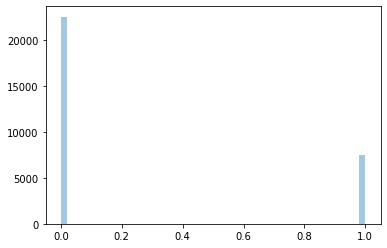

In [18]:
sns.distplot(y, kde=False)

In [19]:
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

upsample_smote_ = SMOTE(sampling_strategy='not majority')
X_upsam_smote_, y_upsam_smote_ = upsample_smote_.fit_sample(X, y)

#upsample_smote_ = SMOTEENN(sampling_strategy='not majority', random_state = 959)
#X_upsam_smote_, y_upsam_smote_ = upsample_smote_.fit_sample(X, y)


In [20]:
smote_df_ = pd.DataFrame(X_upsam_smote_, columns = ml_df.columns)
smote_df_['income_outcome'] = y_upsam_smote_
smote_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45168 entries, 0 to 45167
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   45168 non-null  float64
 1   fnlwght                               45168 non-null  float64
 2   education_num_yr                      45168 non-null  float64
 3   cap_gain                              45168 non-null  float64
 4   cap_loss                              45168 non-null  float64
 5   hours_per_week                        45168 non-null  float64
 6   origin_descent_us                     45168 non-null  float64
 7   age_range_ord                         45168 non-null  float64
 8   education_level_ord                   45168 non-null  float64
 9   workclass_Local-gov                   45168 non-null  float64
 10  workclass_Private                     45168 non-null  float64
 11  workclass_Self-

We see the dataset is more balanced 

In [21]:
pd.crosstab(index=smote_df_['income_outcome'],columns= smote_df_['income_outcome'])

income_outcome      0      1
income_outcome              
0               22584      0
1                   0  22584

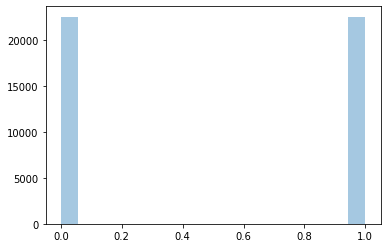

In [22]:
sns.distplot(y_upsam_smote_, kde=False)


In [23]:
#https://scikit-learn.org/0.15/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
num_cv_iterations = 3
#num_instances = len(y)
#num_instances_smote_ = len(y_upsam_smote_)

cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 959)


                         
print(cv_object)


StratifiedShuffleSplit(n_splits=3, random_state=959, test_size=0.2,
            train_size=None)


====Iteration 0  ====

Accuracy:  0.8443890274314214 

f1_score: 0.6640344580043072 

precision_score: 0.718167701863354 

roc_auc_score: 0.7685634569064561 

Confusion Matrix: 

      0    1
0  4154  363
1   573  925 

Train Time:  1.2662040040000004 s

====Iteration 1  ====

Accuracy:  0.8468827930174564 

f1_score: 0.6644808743169399 

precision_score: 0.731355252606255 

roc_auc_score: 0.7673237403394918 

Confusion Matrix: 

      0    1
0  4182  335
1   586  912 

Train Time:  1.5642544010000003 s

====Iteration 2  ====

Accuracy:  0.8470490440565254 

f1_score: 0.6582466567607728 

precision_score: 0.7420435510887772 

roc_auc_score: 0.761634212009637 

Confusion Matrix: 

      0    1
0  4209  308
1   612  886 

Train Time:  1.7204732790000001 s



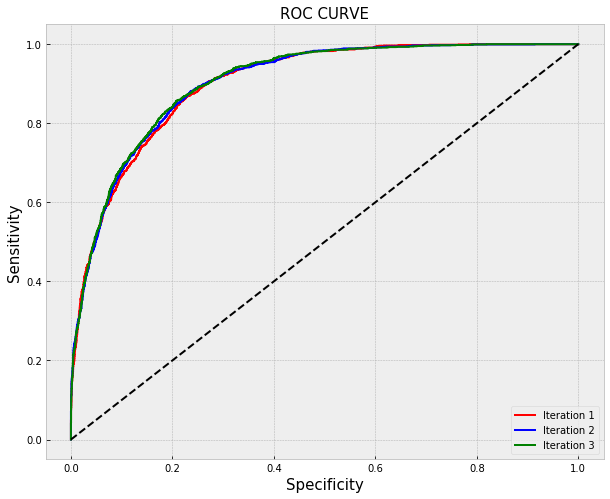

In [24]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
##https://docs.python.org/3/library/time.html#functions

# Setting the parameters for the ROC Curve
plt.rcParams['figure.figsize'] = [10,8]
plt.style.use("bmh")

color = ['red', 'blue', 'green', 'fuchsia', 'cyan']
plt.title("ROC CURVE", fontsize = 15)
plt.xlabel("Specificity", fontsize = 15)
plt.ylabel("Sensitivity", fontsize = 15)


#lr_clf = LogisticRegression(penalty='elasticnet', C=1.0, class_weight=None, solver='saga', l1_ratio = 0.5 )
lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight=None, solver='liblinear')
lr_clf_pipe = make_pipeline(StandardScaler(),lr_clf)


iter_num=0
weights = []

for train_indices, test_indices in cv_object.split(X,y): 

    t = time.process_time()
    
    lr_clf_pipe.fit(X[train_indices], y[train_indices])
    y_hat = lr_clf_pipe.predict(X[test_indices]) # get test set precitions
    
    elapsed_time = time.process_time() - t
    

    # now let's get the accuracy and confusion matrix for these iterations of training/testing
    acc = mt.accuracy_score(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    
    weights.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])

    
    
    prob = lr_clf_pipe.predict_proba(X[test_indices])
    prob_positive = prob[:,1]
    fpr, tpr, threshold = roc_curve(y[test_indices], prob_positive)
    plt.plot(fpr, tpr, color = color[iter_num])
  

    iter_num+=1
iterations = ["Iteration 1", "Iteration 2", "Iteration 3"]  
plt.gca().legend(iterations, loc = 'lower right', frameon = True)
plt.plot([0,1],[0,1], linestyle = '--', color = 'black')
plt.show()
weights = np.array(weights)

In [25]:
weights

array([[ 4.78932954e-01,  7.80494716e-02,  2.22302141e-01,
         2.38916675e+00,  2.65906423e-01,  2.16555001e-01,
         3.34273709e-02, -7.21569569e-02,  1.76102307e-01,
        -1.80716653e-01, -2.08112454e-01, -4.87460356e-02,
        -2.28909317e-01, -1.70522910e-01, -1.29495478e-01,
        -1.58218669e-02,  1.78360064e-02, -8.18375038e-03,
        -1.32613051e-02, -4.01041582e-02, -1.07340735e-02,
        -1.21395640e-02,  6.94185726e-04,  6.71740862e-02,
         8.62011164e-02, -2.44697048e-02,  4.73095974e-02,
        -1.70329519e-01,  1.52263013e-01,  1.43991095e-02,
         4.45815302e-02,  5.92263399e-01, -1.09794209e-01,
        -1.89280927e-01, -1.64170349e-01,  5.54851690e-02,
        -1.55859379e-02,  1.64215610e-02,  2.85108269e-01,
        -1.57399362e-01, -1.38223923e-01, -9.43737463e-02,
        -2.35943049e-01, -3.06939489e-01,  1.92110537e-01,
         9.24846962e-02,  1.16452053e-01,  1.19434963e-01,
        -1.90825891e-02,  1.94644098e-01, -4.76461220e-0

In [26]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)

Let's select the important variables from above and look at education_num_yr, cap_gain, and the levels of marital status 

In [27]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
Xnew = ml_df[['age', 'education_num_yr', 'cap_gain', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'age_range_child', 'age_range_senior']].values

weights = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    lr_clf_pipe.fit(Xnew[train_indices],y[train_indices])
    
    weights.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num =+1
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['age', 'education_num_yr', 'cap_gain', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'age_range_child', 'age_range_senior'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars', 'height': 1000, 'width': 1400, 'font': {'size':14}}

plotly.offline.iplot(fig)

====Iteration 0  ====

Accuracy:  0.8335827098919368 

f1_score: 0.6241081487044687 

precision_score: 0.7133047210300429 

recall_score: 0.554739652870494 

roc_auc_score: 0.740398385213197 

Confusion Matrix: 

      0    1
0  4183  334
1   667  831 

Train Time:  0.12570136600000126 s

====Iteration 1  ====

Accuracy:  0.8314214463840399 

f1_score: 0.6190833959429001 

precision_score: 0.7079037800687286 

recall_score: 0.5500667556742324 

roc_auc_score: 0.7373977789883227 

Confusion Matrix: 

      0    1
0  4177  340
1   674  824 

Train Time:  0.3702822860000001 s

====Iteration 2  ====

Accuracy:  0.8370739817123857 

f1_score: 0.6216216216216217 

precision_score: 0.7371794871794872 

recall_score: 0.5373831775700935 

roc_auc_score: 0.7369227156391535 

Confusion Matrix: 

      0    1
0  4230  287
1   693  805 

Train Time:  0.4546349129999996 s



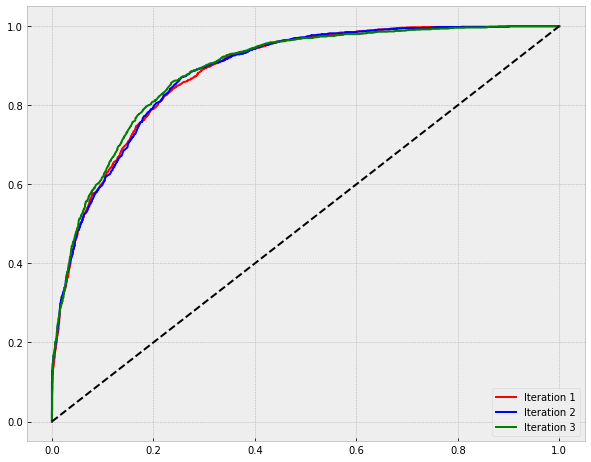

In [28]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    
    
    t = time.process_time()
    lr_clf_pipe.fit(Xnew[train_indices],y[train_indices])
    
    y_hat = lr_clf_pipe.predict(Xnew[test_indices])
    
    elapsed_time = time.process_time() - t
    


    acc = mt.accuracy_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    recal_scor_ = mt.recall_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("recall_score:", recal_scor_, "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    prob = lr_clf_pipe.predict_proba(Xnew[test_indices])
    prob_positive = prob[:,1]
    fpr, tpr, threshold = roc_curve(y[test_indices], prob_positive)
    plt.plot(fpr, tpr, color = color[iter_num])
  

    iter_num+=1
iterations = ["Iteration 1", "Iteration 2", "Iteration 3"]  
plt.gca().legend(iterations, loc = 'lower right', frameon = True)
plt.plot([0,1],[0,1], linestyle = '--', color = 'black')
plt.show()
    

SMOTE SAMPLING

Logistic Regression with hyper parameters from grid search

====Iteration 0  ====

Accuracy:  0.8252158512286916 

f1_score: 0.8303062869425041 

precision_score: 0.8068086883876358 

recall_score: 0.8552136373699358 

roc_auc_score: 0.8252158512286917 

Confusion Matrix: 

      0     1
0  3592   925
1   654  3863 

Train Time:  2.460813988 s

====Iteration 1  ====

Accuracy:  0.8377241531990259 

f1_score: 0.8409978308026029 

precision_score: 0.8243674250478418 

recall_score: 0.8583130396280717 

roc_auc_score: 0.8377241531990259 

Confusion Matrix: 

      0     1
0  3691   826
1   640  3877 

Train Time:  3.2566981109999986 s

====Iteration 2  ====

Accuracy:  0.8336285145007748 

f1_score: 0.8375661947476495 

precision_score: 0.8182010135135135 

recall_score: 0.8578702678769095 

roc_auc_score: 0.8336285145007748 

Confusion Matrix: 

      0     1
0  3656   861
1   642  3875 

Train Time:  2.8956976469999987 s



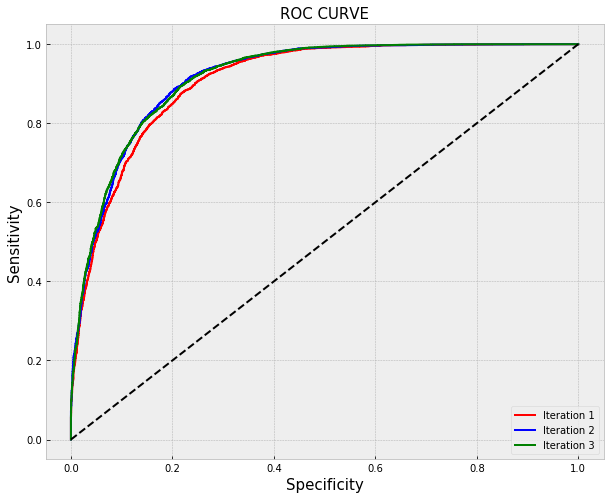

In [29]:
# Setting the parameters for the ROC Curve
plt.rcParams['figure.figsize'] = [10,8]
plt.style.use("bmh")

color = ['red', 'blue', 'green', 'fuchsia', 'cyan']
plt.title("ROC CURVE", fontsize = 15)
plt.xlabel("Specificity", fontsize = 15)
plt.ylabel("Sensitivity", fontsize = 15)


lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter=1e6 )
#lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight=None, solver='liblinear')
lr_clf_pipe = make_pipeline(StandardScaler(),lr_clf)


iter_num=0
weights = []




for train_indices, test_indices in cv_object.split(X_upsam_smote_,y_upsam_smote_): 

    t = time.process_time()
    
    lr_clf_pipe.fit(X_upsam_smote_[train_indices], y_upsam_smote_ [train_indices])
    y_hat = lr_clf_pipe.predict(X_upsam_smote_[test_indices]) # get test set precitions
    
    elapsed_time = time.process_time() - t
    

    # now let's get the accuracy and confusion matrix for these iterations of training/testing
    acc = mt.accuracy_score(y_upsam_smote_ [test_indices],y_hat)
    f1_scor_ = mt.f1_score(y_upsam_smote_ [test_indices],y_hat)
    prec_scor_ = mt.precision_score(y_upsam_smote_ [test_indices], y_hat)
    recal_scor_ = mt.recall_score(y_upsam_smote_ [test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_ [test_indices],y_hat)
    conf = mt.confusion_matrix(y_upsam_smote_ [test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("recall_score:", recal_scor_, "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    
    weights.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])

    
    
    prob = lr_clf_pipe.predict_proba(X_upsam_smote_[test_indices])
    prob_positive = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_upsam_smote_ [test_indices], prob_positive)
    plt.plot(fpr, tpr, color = color[iter_num])
  

    iter_num+=1
iterations = ["Iteration 1", "Iteration 2", "Iteration 3"]  
plt.gca().legend(iterations, loc = 'lower right', frameon = True)
plt.plot([0,1],[0,1], linestyle = '--', color = 'black')
plt.show()
weights = np.array(weights)

In [30]:
error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)

In [31]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
#https://scikit-learn.org/stable/modules/grid_search.html#gridsearch-scoring
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html



X_train_smote_, X_test_smote_, y_train_smote_, y_test_smote_ = train_test_split( X_upsam_smote_, y_upsam_smote_, test_size=0.2, random_state=959)




tuned_parameters = [{'C': [1e-1, 0.5, 1], 
                     'max_iter' : [1e6], 
                     'penalty' : ['l2'], 
                     'class_weight' : [None], 
                     'solver' : ['sag']
                    }]


clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='f1', cv=cv_object)

clf.fit(X_train_smote_,y_train_smote_)

    
print(clf.best_params_)

{'C': 0.1, 'class_weight': None, 'max_iter': 1000000.0, 'penalty': 'l2', 'solver': 'sag'}


In [32]:
#Xnew_smote_ = ml_df[['age','cap_gain','sex_Male', 'marital_stat_Unmarried', 'marital_status_Married-civ-spouse', 'education_Preschool','education_Prof-school']].values

Xnew_smote_ = ml_df[['age','cap_gain','sex_Male', 'hours_per_week', 'education_num_yr']].values

Xnew_upsam_smote_, ynew_upsam_smote_ = upsample_smote_.fit_sample(Xnew_smote_, y)

weights = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew_upsam_smote_, ynew_upsam_smote_)):
    lr_clf_pipe.fit(Xnew_upsam_smote_[train_indices],ynew_upsam_smote_[train_indices])
    
    weights.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num =+1
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {#'x': ['age','cap_gain','sex_Male', 'marital_stat_Unmarried', 'marital_status_Married-civ-spouse', 'education_Preschool','education_Prof-school'],
          'x': ['age','cap_gain','sex_Male', 'hours_per_week', 'education_num_yr'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars reduced features', 'height': 1000, 'width': 1400, 'font': {'size':14}}

plotly.offline.iplot(fig)

    


====Iteration 0  ====

Accuracy:  0.7576931591764445 

f1_score: 0.7577199778638628 

precision_score: 0.7576361221779548 

recall_score: 0.7578038521142351 

roc_auc_score: 0.7576931591764446 

Confusion Matrix: 

      0     1
0  3422  1095
1  1094  3423 

Train Time:  0.08985794800003077 s

====Iteration 1  ====

Accuracy:  0.758357316803188 

f1_score: 0.7539172584826964 

precision_score: 0.7680293982544787 

recall_score: 0.7403143679433252 

roc_auc_score: 0.758357316803188 

Confusion Matrix: 

      0     1
0  3507  1010
1  1173  3344 

Train Time:  0.34197726400003603 s

====Iteration 2  ====

Accuracy:  0.7600177108700464 

f1_score: 0.7579816923420407 

precision_score: 0.7644674622832696 

recall_score: 0.7516050475979632 

roc_auc_score: 0.7600177108700463 

Confusion Matrix: 

      0     1
0  3471  1046
1  1122  3395 

Train Time:  0.30831068899999536 s



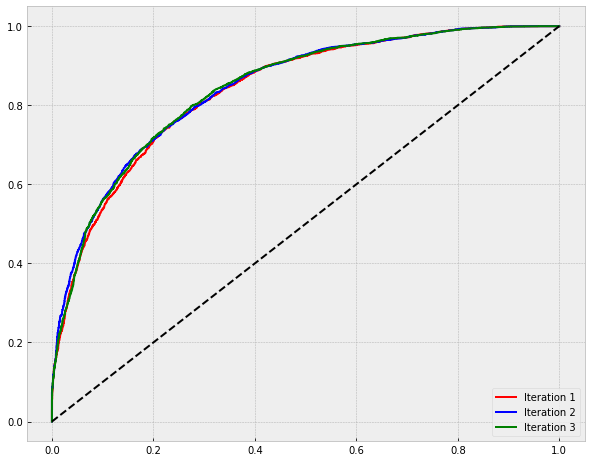

In [33]:
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew_upsam_smote_, ynew_upsam_smote_)):
    
   
    
    t = time.process_time()
    lr_clf_pipe.fit(Xnew_upsam_smote_[train_indices],ynew_upsam_smote_[train_indices])
    
    y_hat = lr_clf_pipe.predict(Xnew_upsam_smote_[test_indices])
    
    elapsed_time = time.process_time() - t
    


    acc = mt.accuracy_score(ynew_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(ynew_upsam_smote_[test_indices],y_hat)
    f1_scor_ = mt.f1_score(ynew_upsam_smote_[test_indices],y_hat)
    prec_scor_ = mt.precision_score(ynew_upsam_smote_[test_indices], y_hat)
    recal_scor_ = mt.recall_score(ynew_upsam_smote_[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(ynew_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(ynew_upsam_smote_[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("recall_score:", recal_scor_, "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    prob = lr_clf_pipe.predict_proba(Xnew_upsam_smote_[test_indices])
    prob_positive = prob[:,1]
    fpr, tpr, threshold = roc_curve(ynew_upsam_smote_[test_indices], prob_positive)
    plt.plot(fpr, tpr, color = color[iter_num])
  

    iter_num+=1
iterations = ["Iteration 1", "Iteration 2", "Iteration 3"]  
plt.gca().legend(iterations, loc = 'lower right', frameon = True)
plt.plot([0,1],[0,1], linestyle = '--', color = 'black')
plt.show()

In [34]:
svm_clf = SVC(C=0.5, kernel='rbf', gamma='auto') 


for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_upsam_smote_,y_upsam_smote_)): 
    

    ML_std_clf.fit(X_upsam_smote_[train_indices])
    X_train_scaled = ML_std_clf.transform(X_upsam_smote_[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X_upsam_smote_[test_indices]) 
    
    t = time.process_time()

    svm_clf.fit(X_train_scaled, y_upsam_smote_[train_indices])  

    y_hat = svm_clf.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t

    acc = mt.accuracy_score(y_upsam_smote_[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y_upsam_smote_[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y_upsam_smote_[test_indices], y_hat)
    recal_scor_ = mt.recall_score(y_upsam_smote_[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(y_upsam_smote_[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("recall_score:", recal_scor_, "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1

====Iteration 0  ====

Accuracy:  0.8730352003542174 

f1_score: 0.8734693877551021 

precision_score: 0.8704925241864556 

recall_score: 0.876466681425725 

roc_auc_score: 0.8730352003542173 

Confusion Matrix: 

      0     1
0  3928   589
1   558  3959 

Train Time:  89.054067374 s

====Iteration 1  ====

Accuracy:  0.8754704449856099 

f1_score: 0.8746238716148446 

precision_score: 0.8806104129263914 

recall_score: 0.8687181757803852 

roc_auc_score: 0.87547044498561 

Confusion Matrix: 

      0     1
0  3985   532
1   593  3924 

Train Time:  88.32983795899997 s

====Iteration 2  ====

Accuracy:  0.8806730130617667 

f1_score: 0.8806201550387596 

precision_score: 0.8810104143585198 

recall_score: 0.8802302413106043 

roc_auc_score: 0.8806730130617667 

Confusion Matrix: 

      0     1
0  3980   537
1   541  3976 

Train Time:  87.53102154199996 s



In [35]:
#SDG parameter best search
tuned_parameters = [{'alpha': [1e-3,1e-2, 1e-1], 
                     'fit_intercept' : [True],
                     'l1_ratio' : [0],
                     'learning_rate': ['optimal'], 
                     'n_iter_no_change': [5], 
                     'loss': ['hinge'], 
                     'penalty': ['l2'],
                     'max_iter' : [1e6],
                     'n_jobs': [-1]
                    }]


clf = GridSearchCV( SGDClassifier(), tuned_parameters, scoring='f1', cv=cv_object)

clf.fit(X_train_smote_,y_train_smote_)

    
print(clf.best_params_)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000000.0, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2'}


In [36]:
regularize_const = 0.1
iterations = 10
#svm_sgd = SGDClassifier(alpha=regularize_const,
#        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
#        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

svm_sgd = SGDClassifier(alpha=0.001,
        fit_intercept=True, l1_ratio=0.00, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', max_iter = 1e6)

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_upsam_smote_,y_upsam_smote_)): 
    
    
    ML_std_clf.fit(X_upsam_smote_[train_indices])
    X_train_scaled = ML_std_clf.transform(X_upsam_smote_[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X_upsam_smote_[test_indices]) 

    t = time.process_time()
    
    svm_sgd.fit(X_train_scaled,y_upsam_smote_[train_indices])
    yhat = svm_sgd.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t
    
    acc = mt.accuracy_score(y_upsam_smote_[test_indices],yhat)
    f1_scor_ = mt.f1_score(y_upsam_smote_[test_indices],yhat)
    prec_scor_ = mt.precision_score(y_upsam_smote_[test_indices], yhat)
    recal_scor_ = mt.recall_score(y_upsam_smote_[test_indices], yhat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_[test_indices],yhat)
    conf = mt.confusion_matrix(y_upsam_smote_[test_indices],yhat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("recall_score:", recal_scor_, "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1

====Iteration 0  ====

Accuracy:  0.821784370157184 

f1_score: 0.8300970873786409 

precision_score: 0.7931034482758621 

recall_score: 0.8707106486606154 

roc_auc_score: 0.821784370157184 

Confusion Matrix: 

      0     1
0  3491  1026
1   584  3933 

Train Time:  0.3097887979999996 s

====Iteration 1  ====

Accuracy:  0.8386096967013504 

f1_score: 0.8447614991482112 

precision_score: 0.8137435897435897 

recall_score: 0.8782377684303742 

roc_auc_score: 0.8386096967013504 

Confusion Matrix: 

      0     1
0  3609   908
1   550  3967 

Train Time:  0.6703096070000356 s

====Iteration 2  ====

Accuracy:  0.8362851450077485 

f1_score: 0.8421389689401217 

precision_score: 0.8130667765869745 

recall_score: 0.8733672791675892 

roc_auc_score: 0.8362851450077484 

Confusion Matrix: 

      0     1
0  3610   907
1   572  3945 

Train Time:  0.6515679799999816 s



In [37]:
for (train_indices, test_indices) in cv_object.split(X_upsam_smote_,y_upsam_smote_): 
    
    X_train = X_upsam_smote_[train_indices]
    y_train = y_upsam_smote_[train_indices]
    
    X_test = X_upsam_smote_[test_indices]
    y_test = y_upsam_smote_[test_indices]
    
    ML_std_clf.fit(X_train)
    X_train_scaled_smote_ = ML_std_clf.transform(X_train) 
    X_test_scaled_smote_ = ML_std_clf.transform(X_test) 

In [38]:
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') 
t = time.process_time()
svm_clf.fit(X_train_scaled_smote_, y_train)  

y_hat = svm_clf.predict(X_test_scaled_smote_) 

elapsed_time = time.process_time() - t


acc = mt.accuracy_score(y_test,y_hat)
f1_scor_ = mt.f1_score(y_test,y_hat)
prec_scor_ = mt.precision_score(y_test, y_hat)
recal_scor_ = mt.recall_score(y_test, y_hat)
auc_scor_ = mt.roc_auc_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)


print("Accuracy: ", acc, "\n" )
print("f1_score:", f1_scor_, "\n")
print("precision_score:",prec_scor_ , "\n")
print("recall_score:", recal_scor_, "\n")
print("roc_auc_score:",auc_scor_ , "\n")
print("Confusion Matrix: \n")
print (pd.DataFrame(conf),"\n")
print("Train Time: ", elapsed_time,  "s\n")

Accuracy:  0.8363958379455391 

f1_score: 0.8438622438199873 

precision_score: 0.8070317235805213 

recall_score: 0.8842151870710648 

roc_auc_score: 0.8363958379455391 

Confusion Matrix: 

      0     1
0  3562   955
1   523  3994 

Train Time:  142.09362290900003 s



In [39]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(14223, 70)
(14223,)
[7110 7113]


[[ 3.81576764e-01  4.89925172e-02  1.99049700e-01  1.95164401e+00
   1.91342966e-01  2.09279674e-01  1.83206631e-02 -8.97661523e-02
   1.32001614e-01 -1.22861399e-01 -1.53186536e-01 -3.24391616e-02
  -1.85115445e-01 -1.04052809e-01 -4.17406059e-02 -3.06214173e-03
   3.55039557e-02 -1.07085243e-02 -1.16520925e-02 -3.99617937e-02
   1.74662131e-03 -1.11740320e-02  5.68004754e-03  2.46915363e-02
   1.26337785e-01 -1.08716285e-02 -1.29751512e-02 -1.66425733e-01
   1.71596722e-01  1.53730421e-02  3.74907563e-02  3.75987629e-01
  -6.23996468e-02 -7.38009188e-02 -1.11138356e-01  2.05733229e-02
  -1.58661123e-02 -2.66234439e-02  1.63378079e-01 -1.83005526e-01
  -1.51152563e-01 -9.33764984e-02 -2.80862192e-01 -1.33675668e-01
   8.98008410e-02  6.00695374e-02  5.02690765e-02  5.66525273e-02
  -4.85934994e-02 -2.23442084e-02 -5.00188070e-02 -1.10931742e-01
  -3.06446335e-02  2.46836905e-01  2.43797031e-01  1.58677095e-01
   1.96273975e-01  2.54958282e-02  2.79021818e-01  1.83206631e-02
  -1.23453

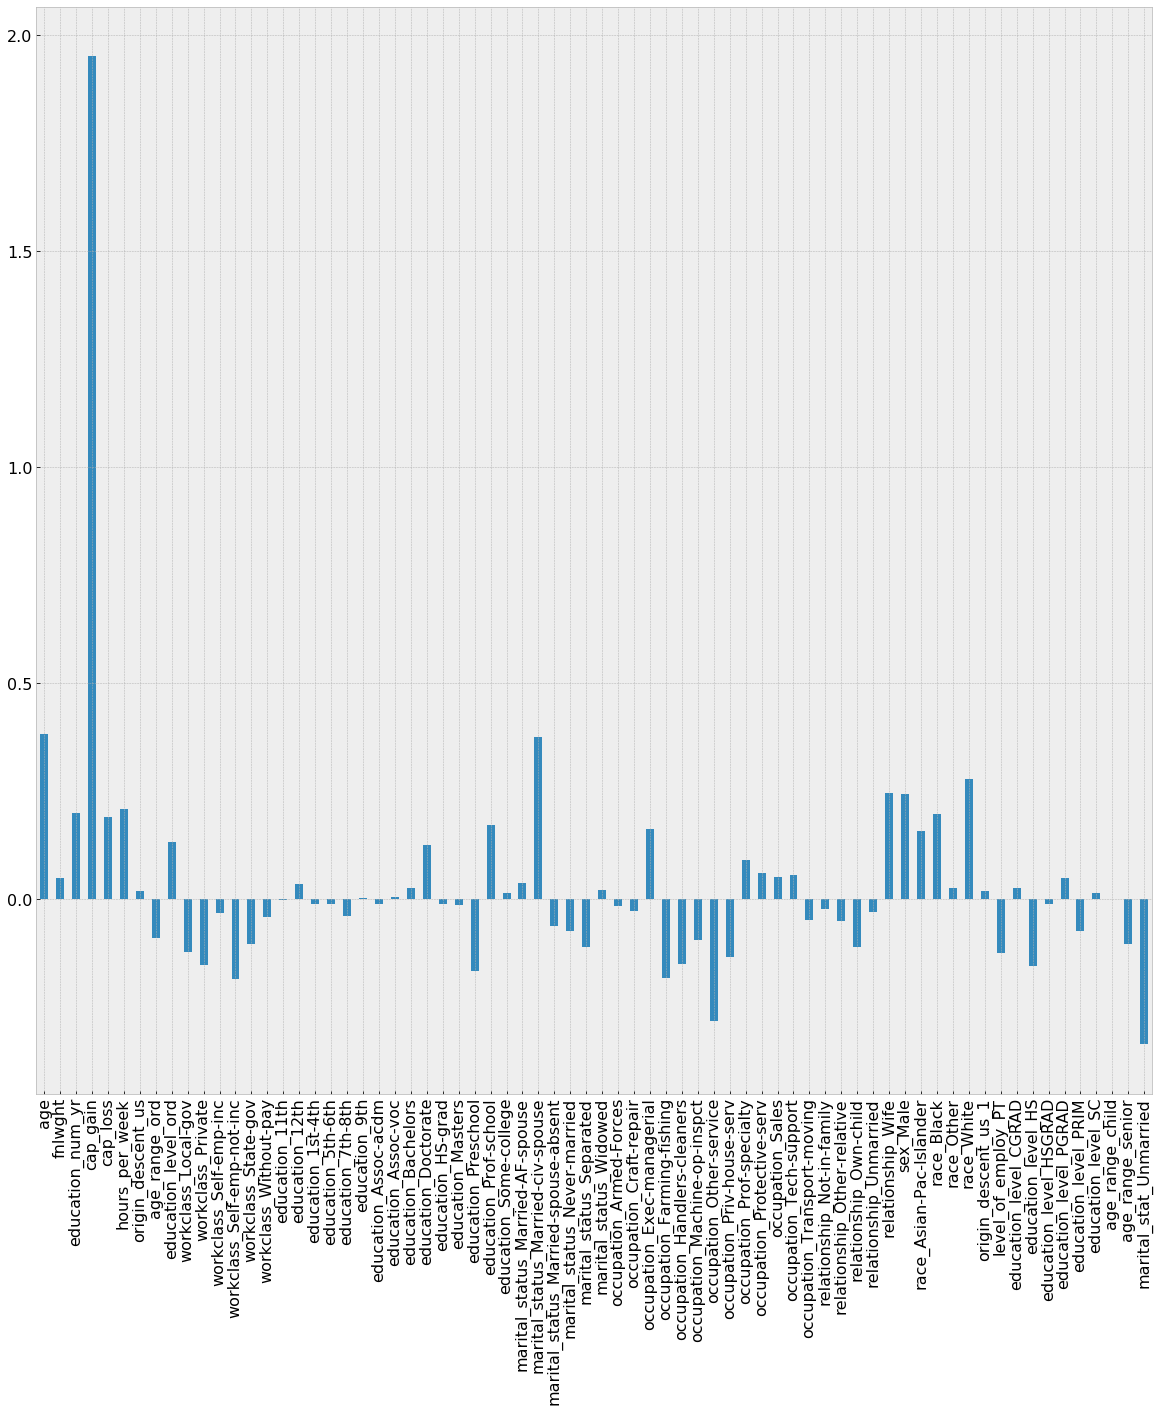

In [40]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=ml_df.columns)
weights.plot(kind='bar',figsize=(20,20), fontsize=16)

In [41]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

df_tested_on = smote_df_.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['income_outcome'] = y_upsam_smote_[svm_clf.support_] 

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14223 entries, 656 to 29620
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   14223 non-null  float64
 1   fnlwght                               14223 non-null  float64
 2   education_num_yr                      14223 non-null  float64
 3   cap_gain                              14223 non-null  float64
 4   cap_loss                              14223 non-null  float64
 5   hours_per_week                        14223 non-null  float64
 6   origin_descent_us                     14223 non-null  float64
 7   age_range_ord                         14223 non-null  float64
 8   education_level_ord                   14223 non-null  float64
 9   workclass_Local-gov                   14223 non-null  float64
 10  workclass_Private                     14223 non-null  float64
 11  workclass_Sel

<Figure size 720x288 with 0 Axes>

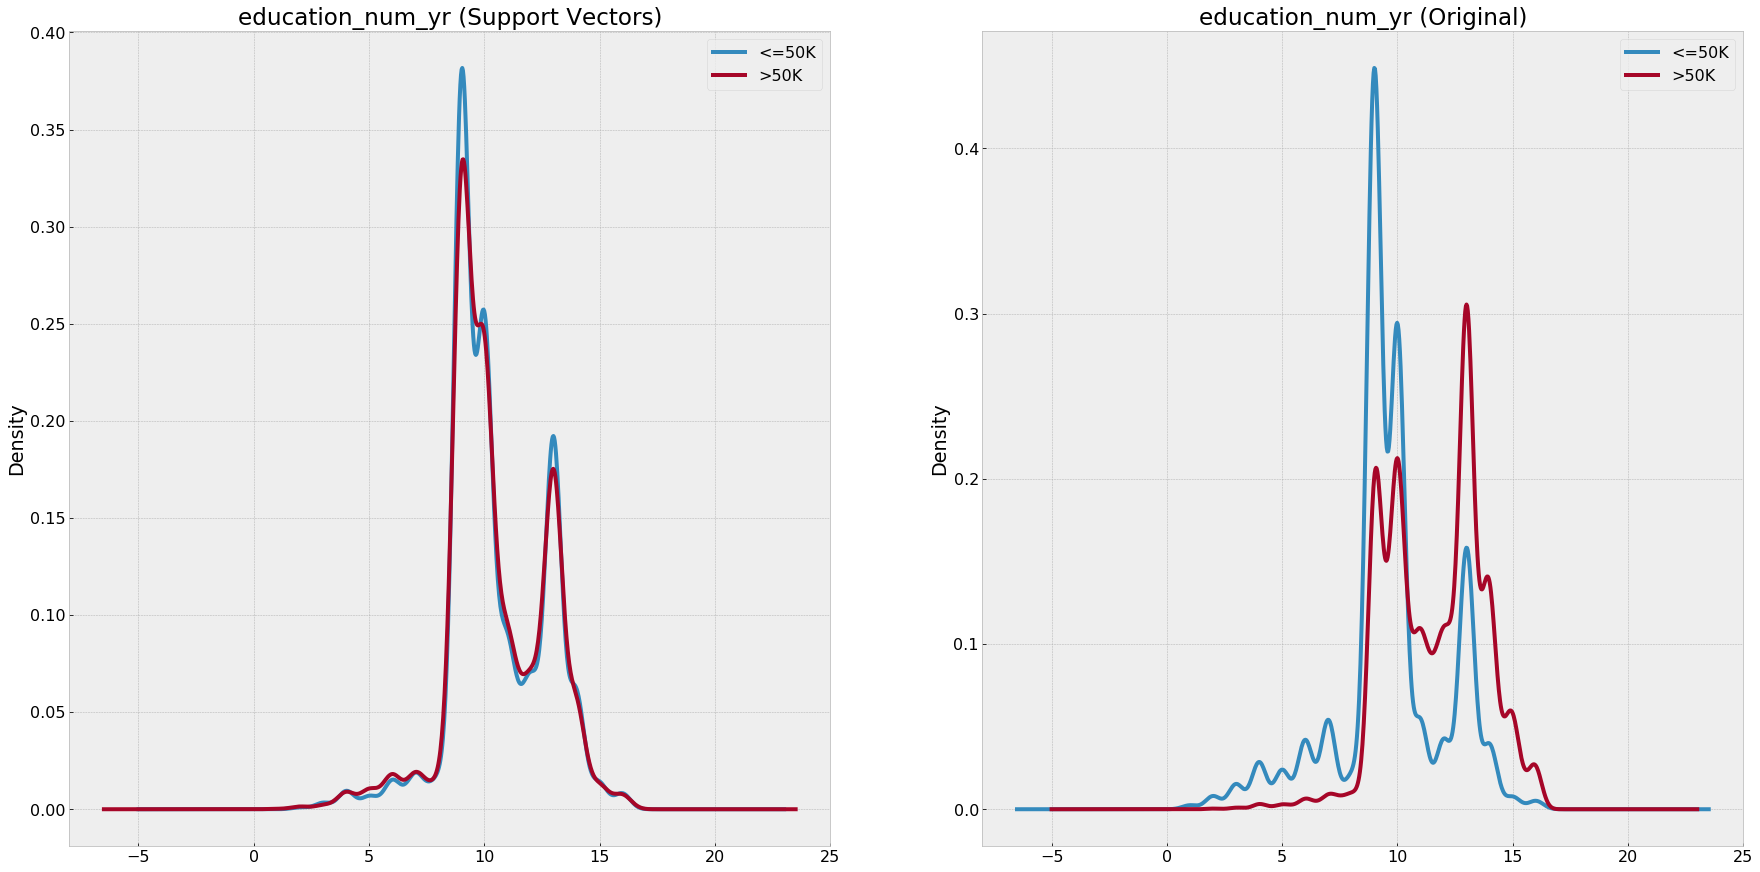

<Figure size 720x288 with 0 Axes>

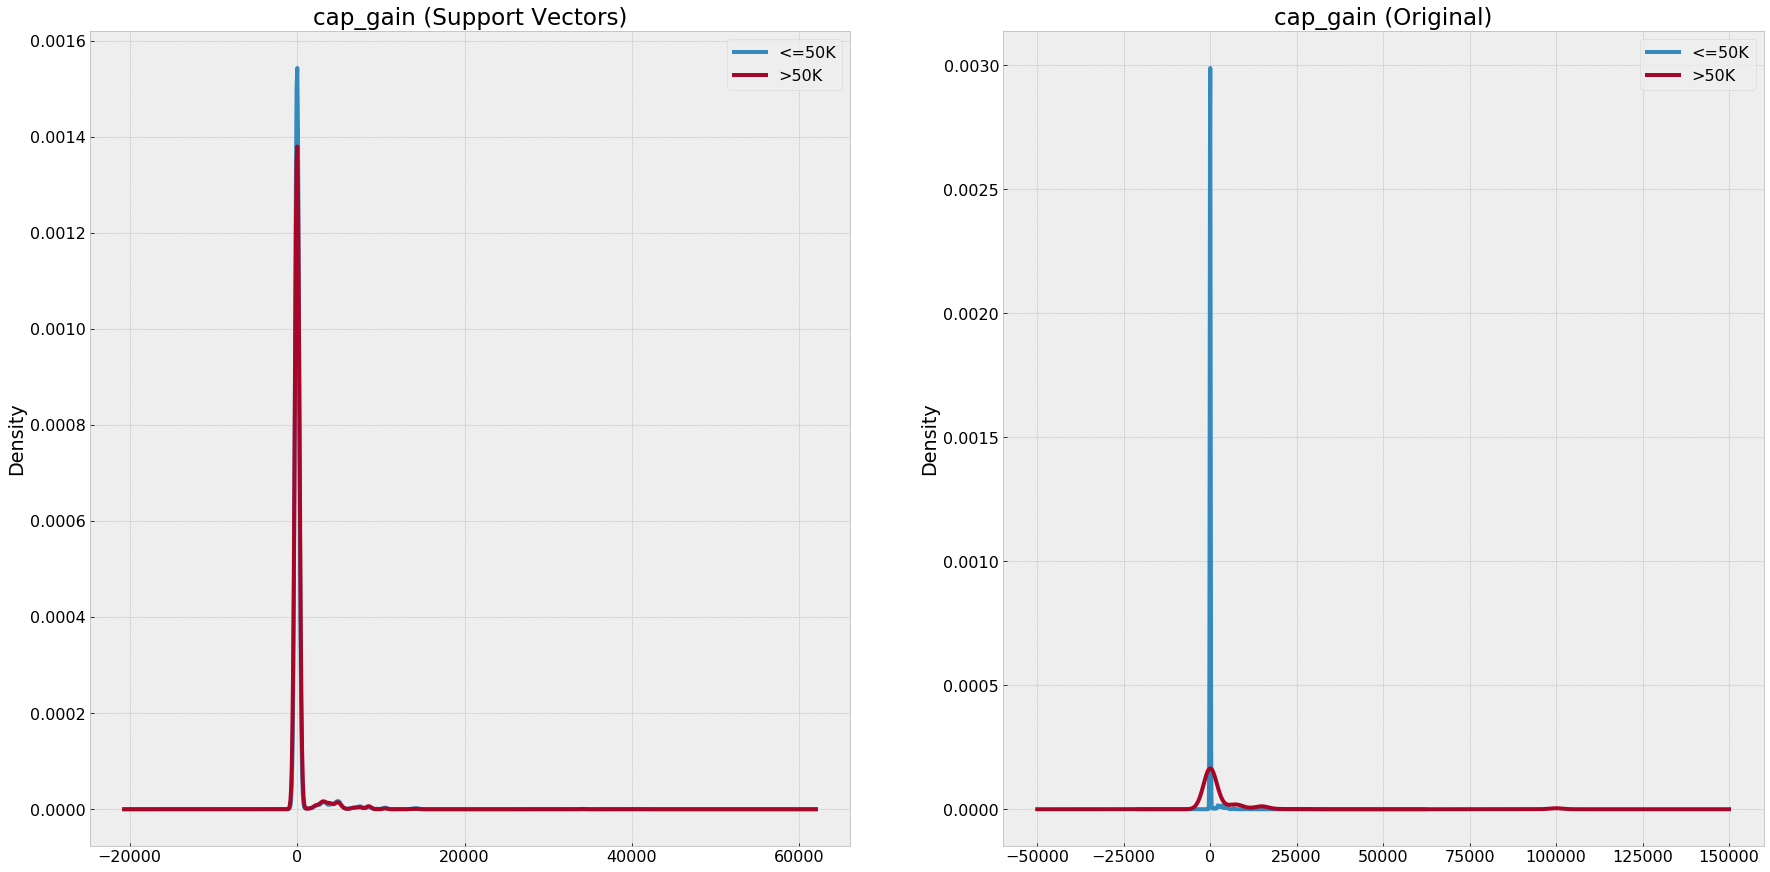

<Figure size 720x288 with 0 Axes>

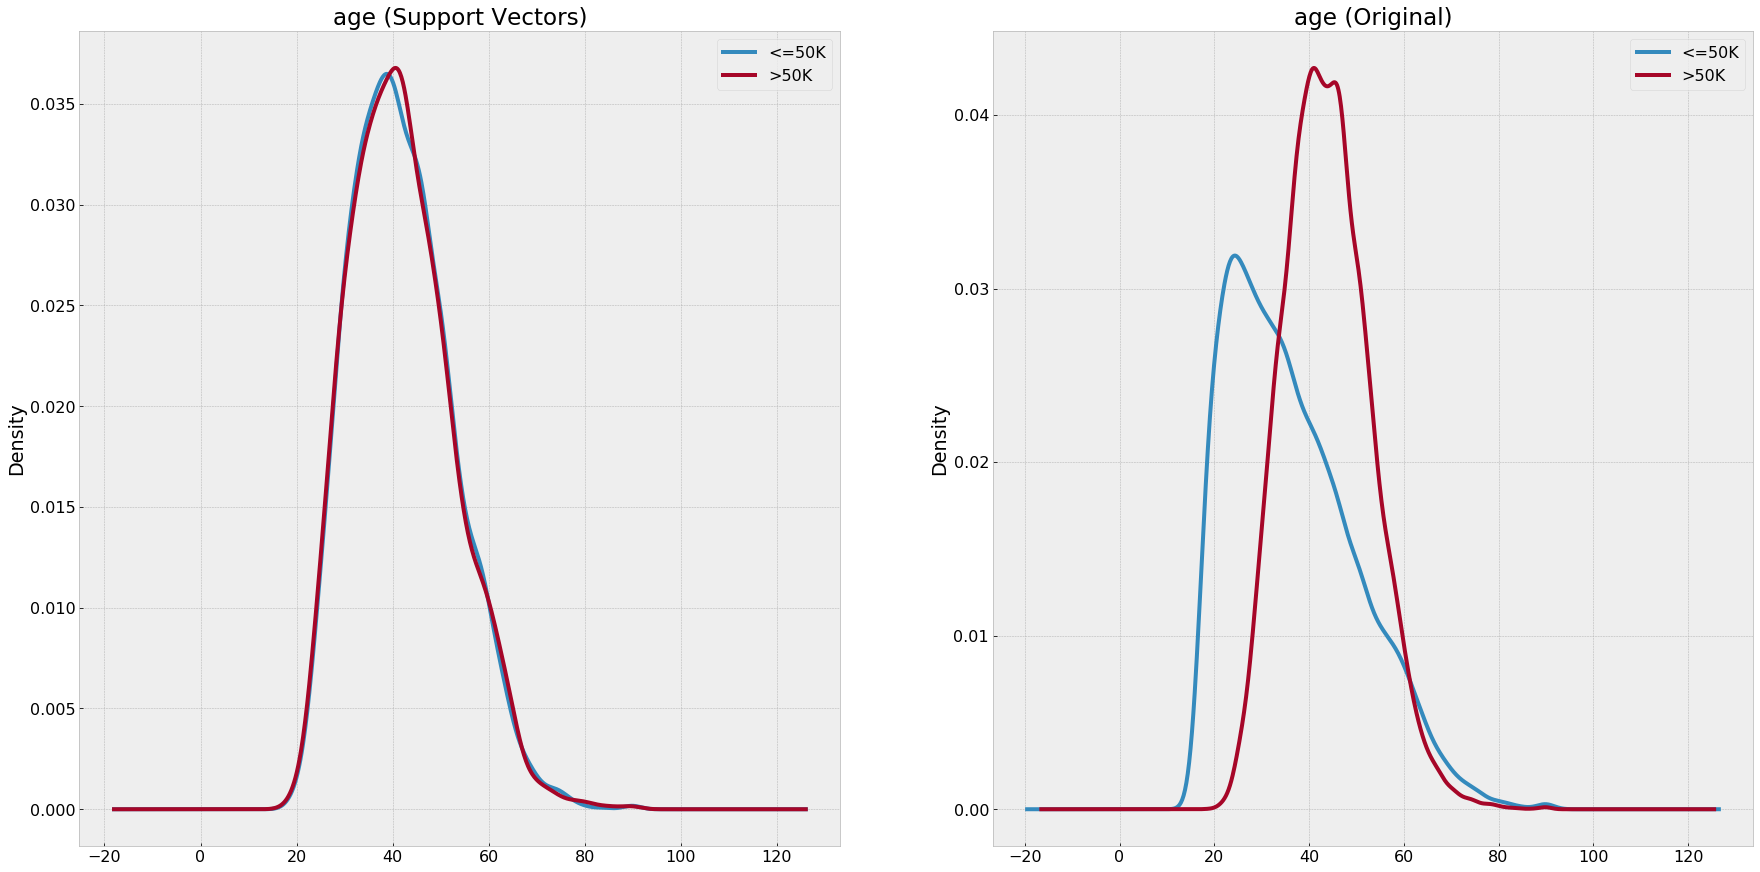

<Figure size 720x288 with 0 Axes>

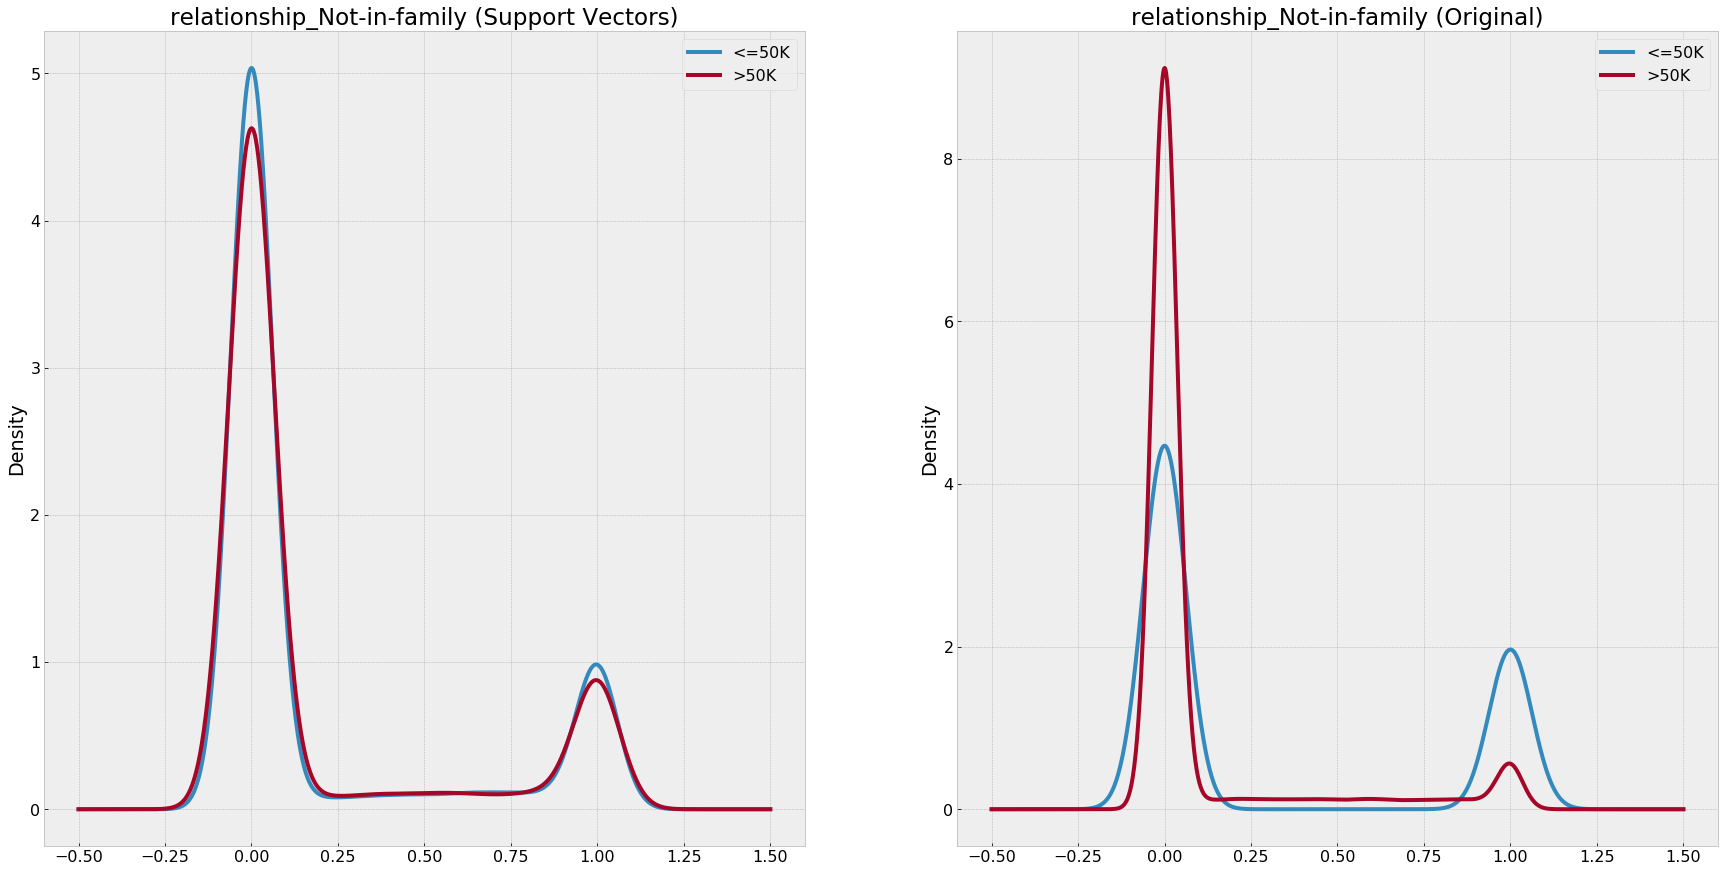

<Figure size 720x288 with 0 Axes>

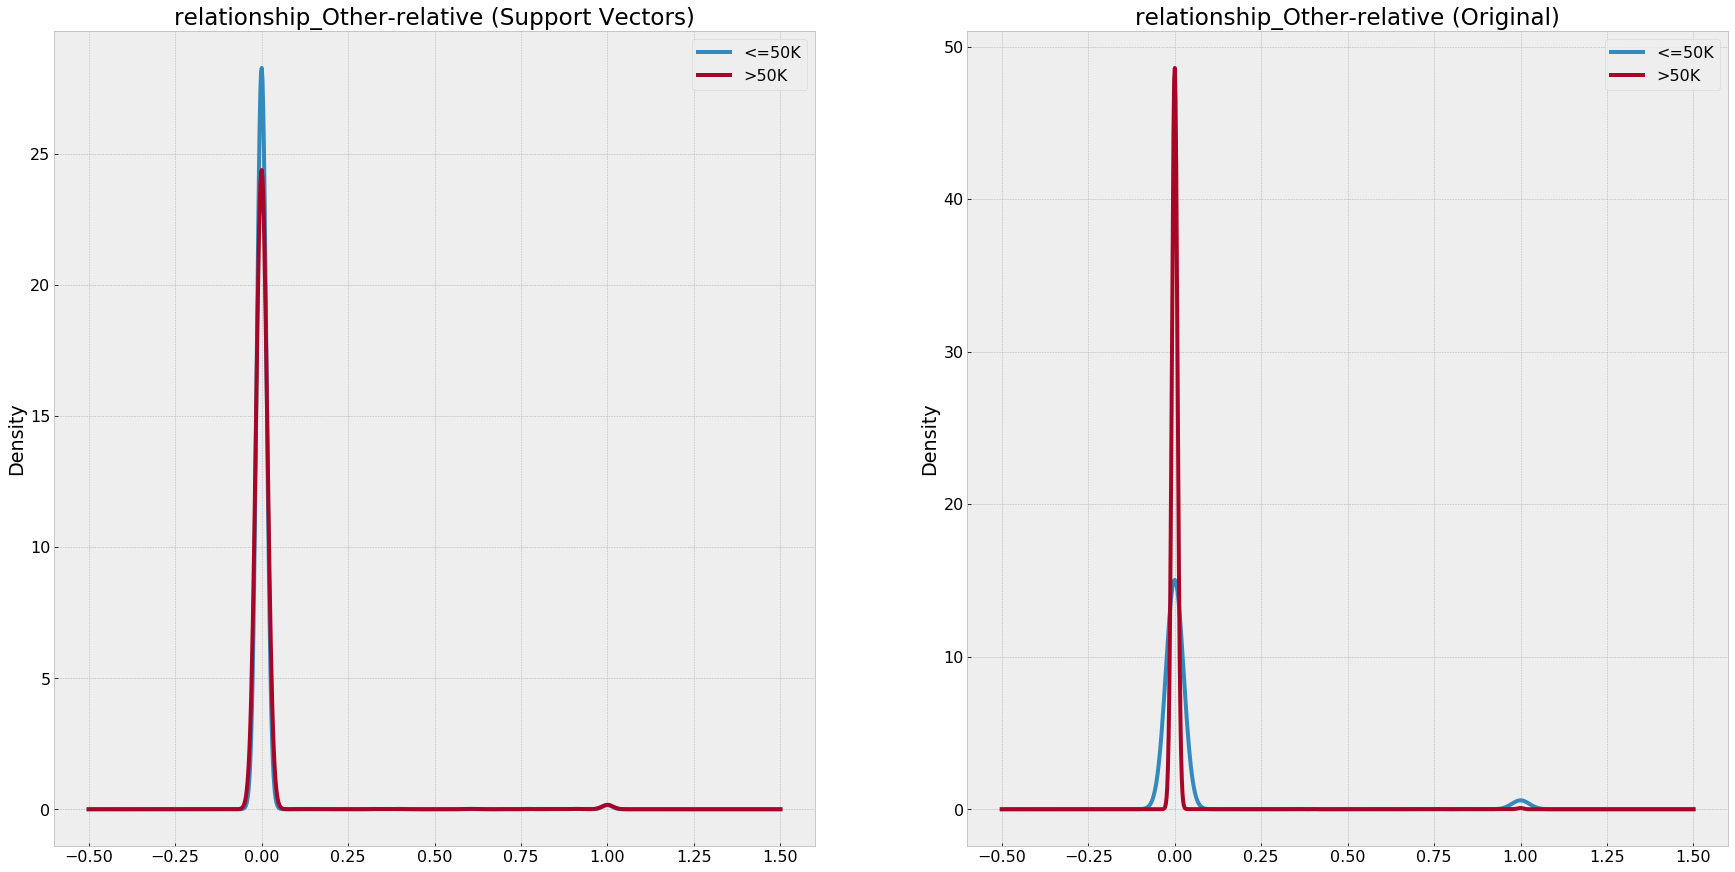

<Figure size 720x288 with 0 Axes>

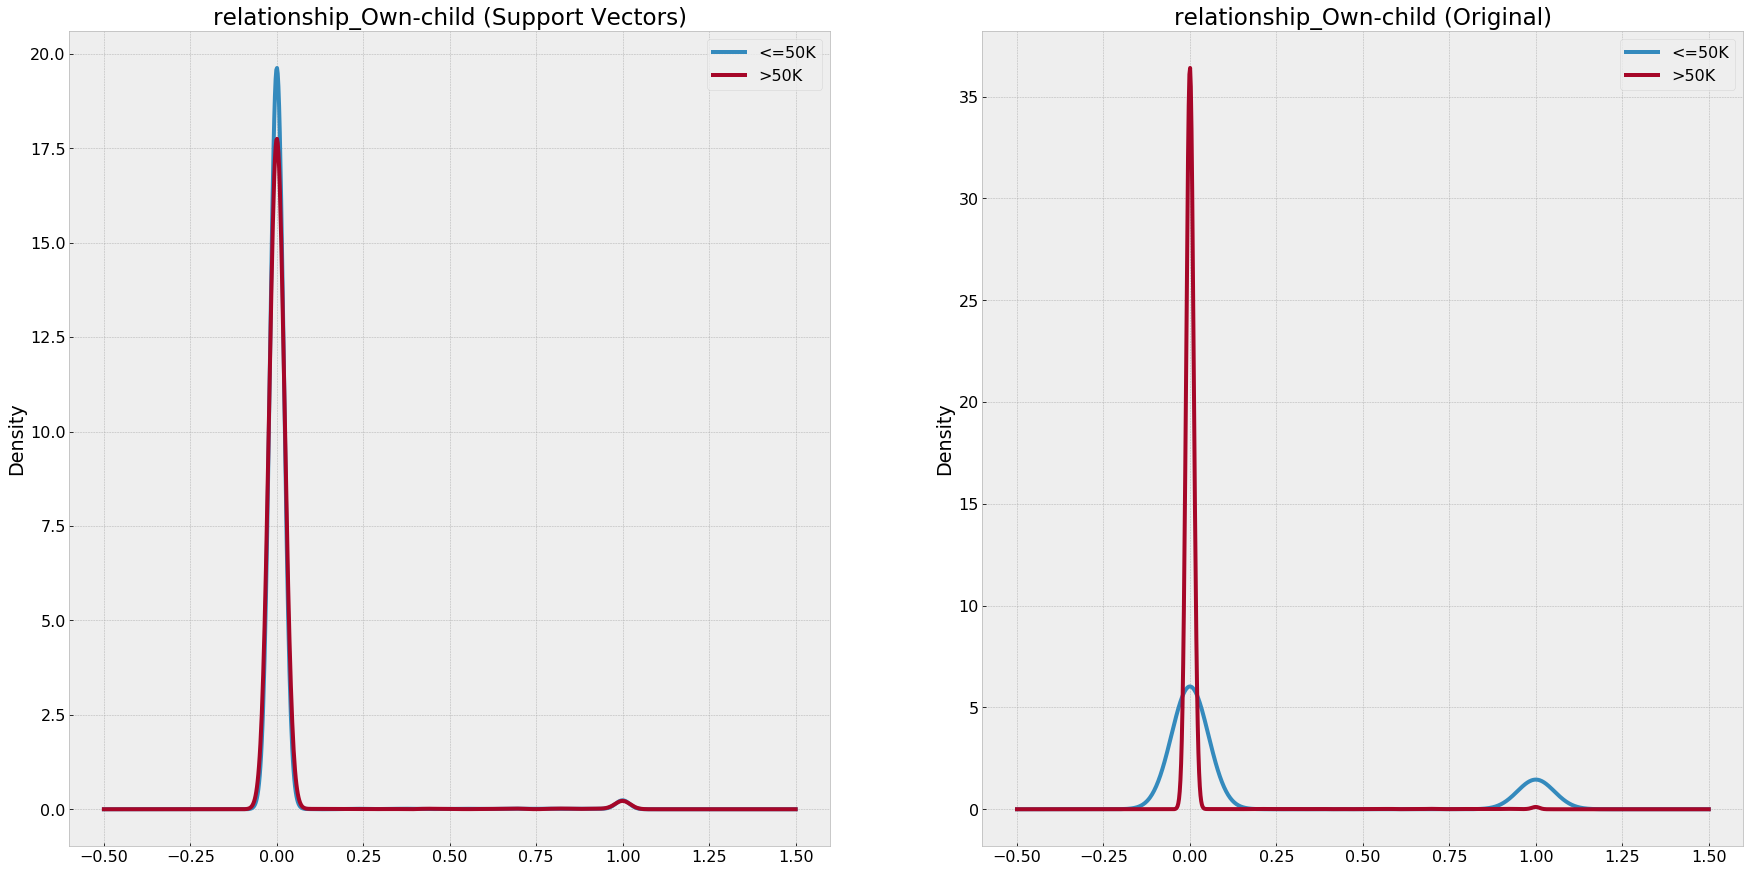

<Figure size 720x288 with 0 Axes>

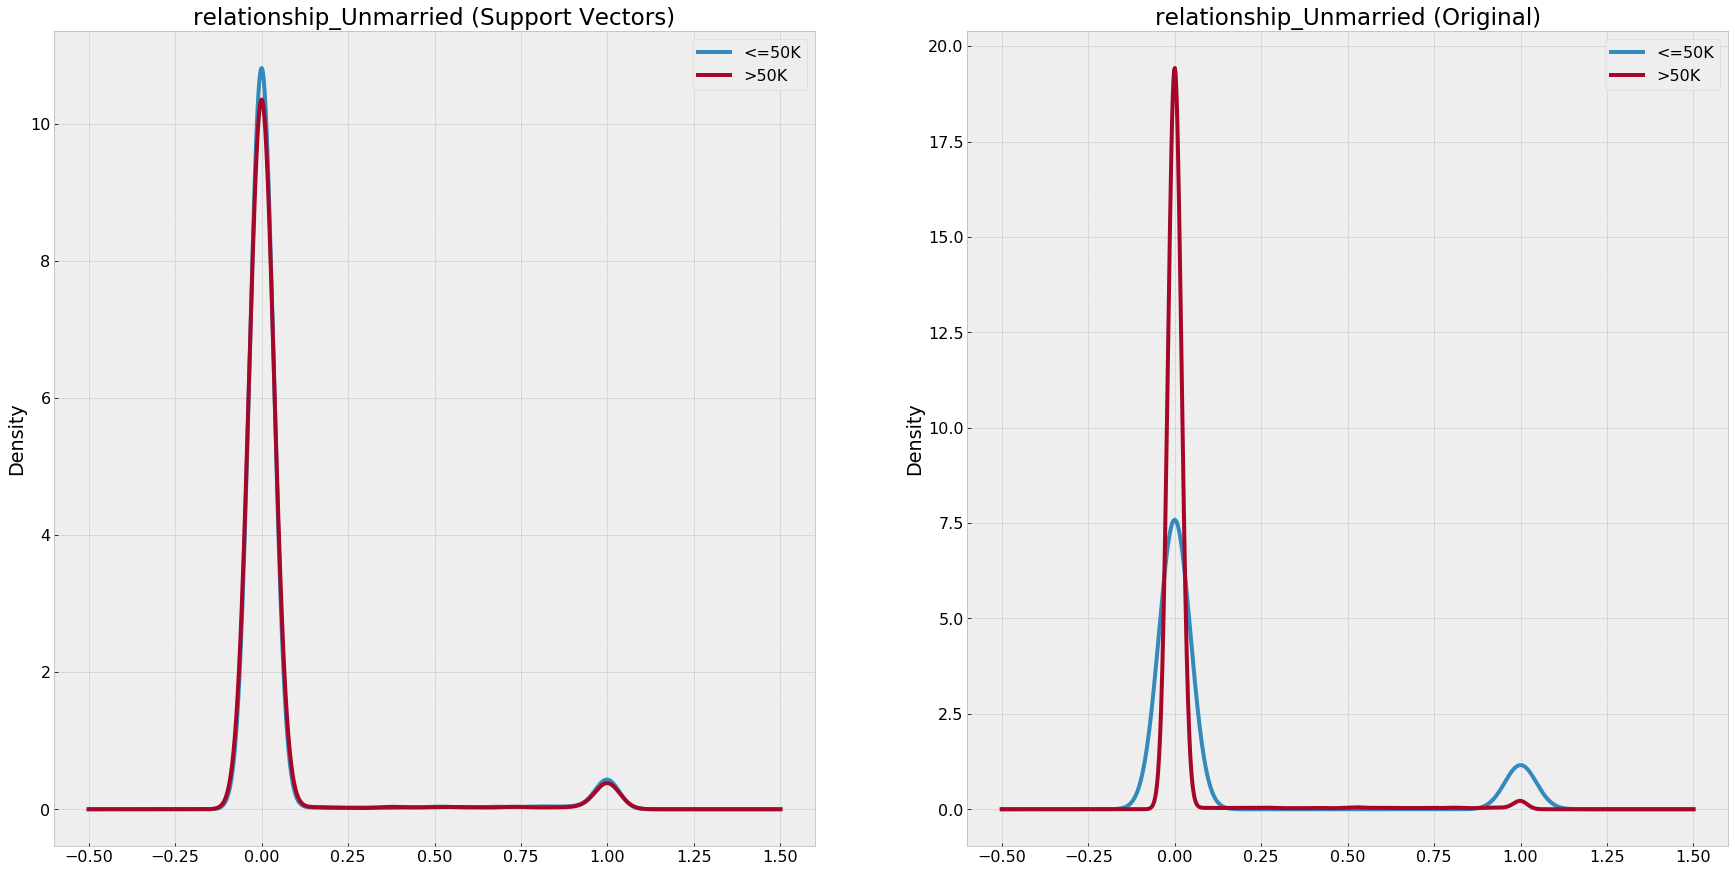

<Figure size 720x288 with 0 Axes>

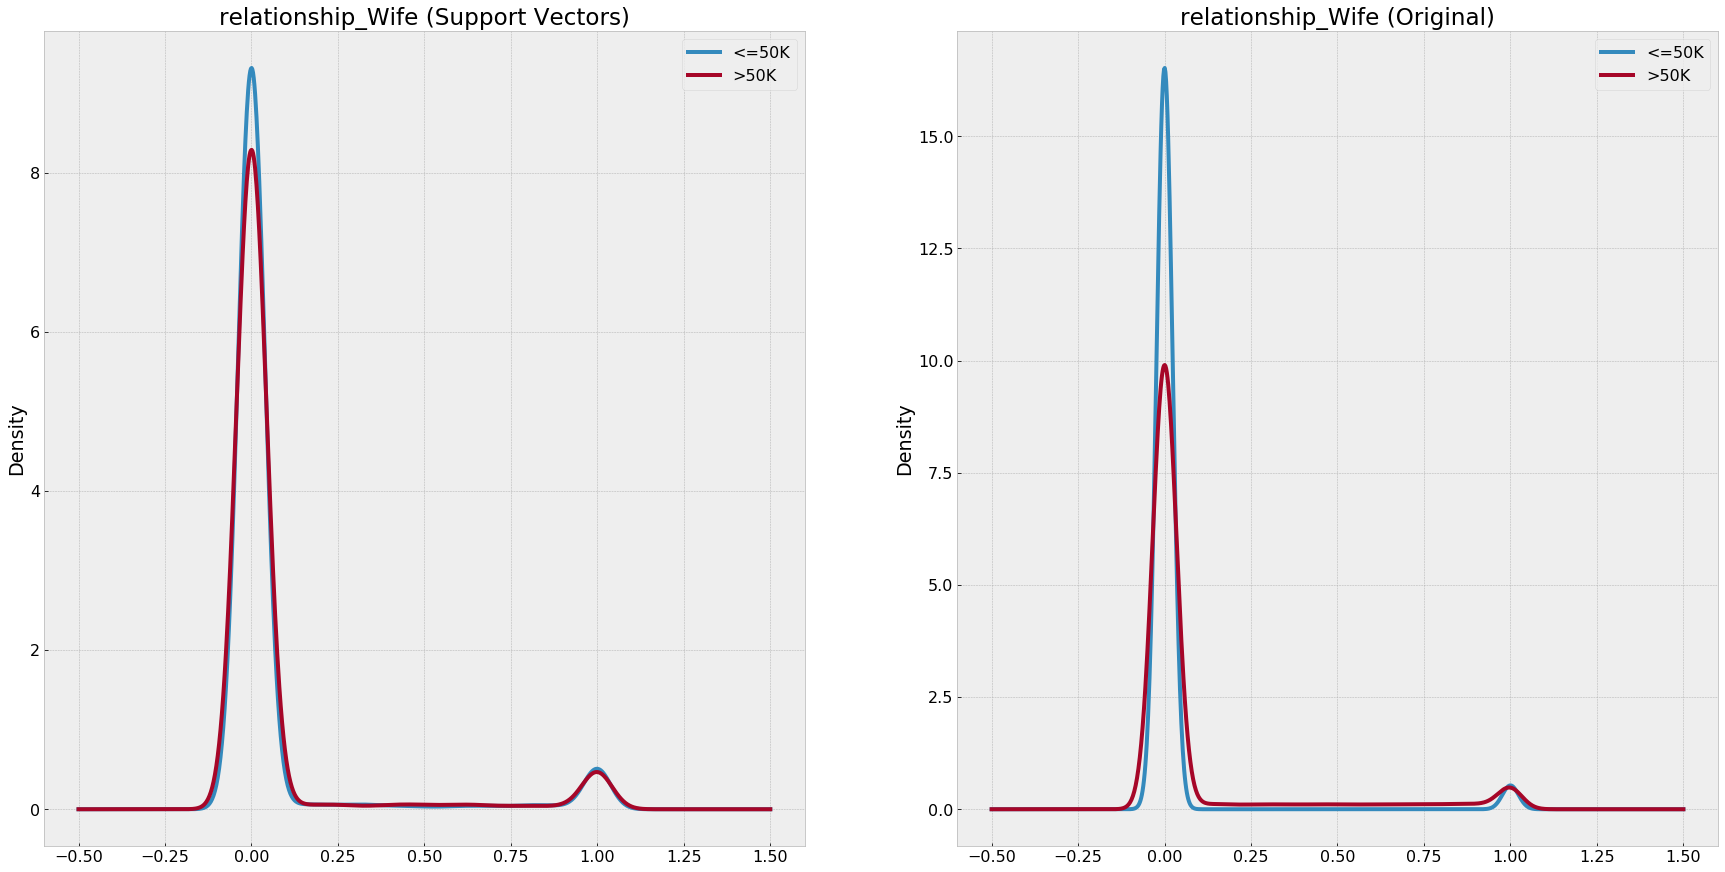

<Figure size 720x288 with 0 Axes>

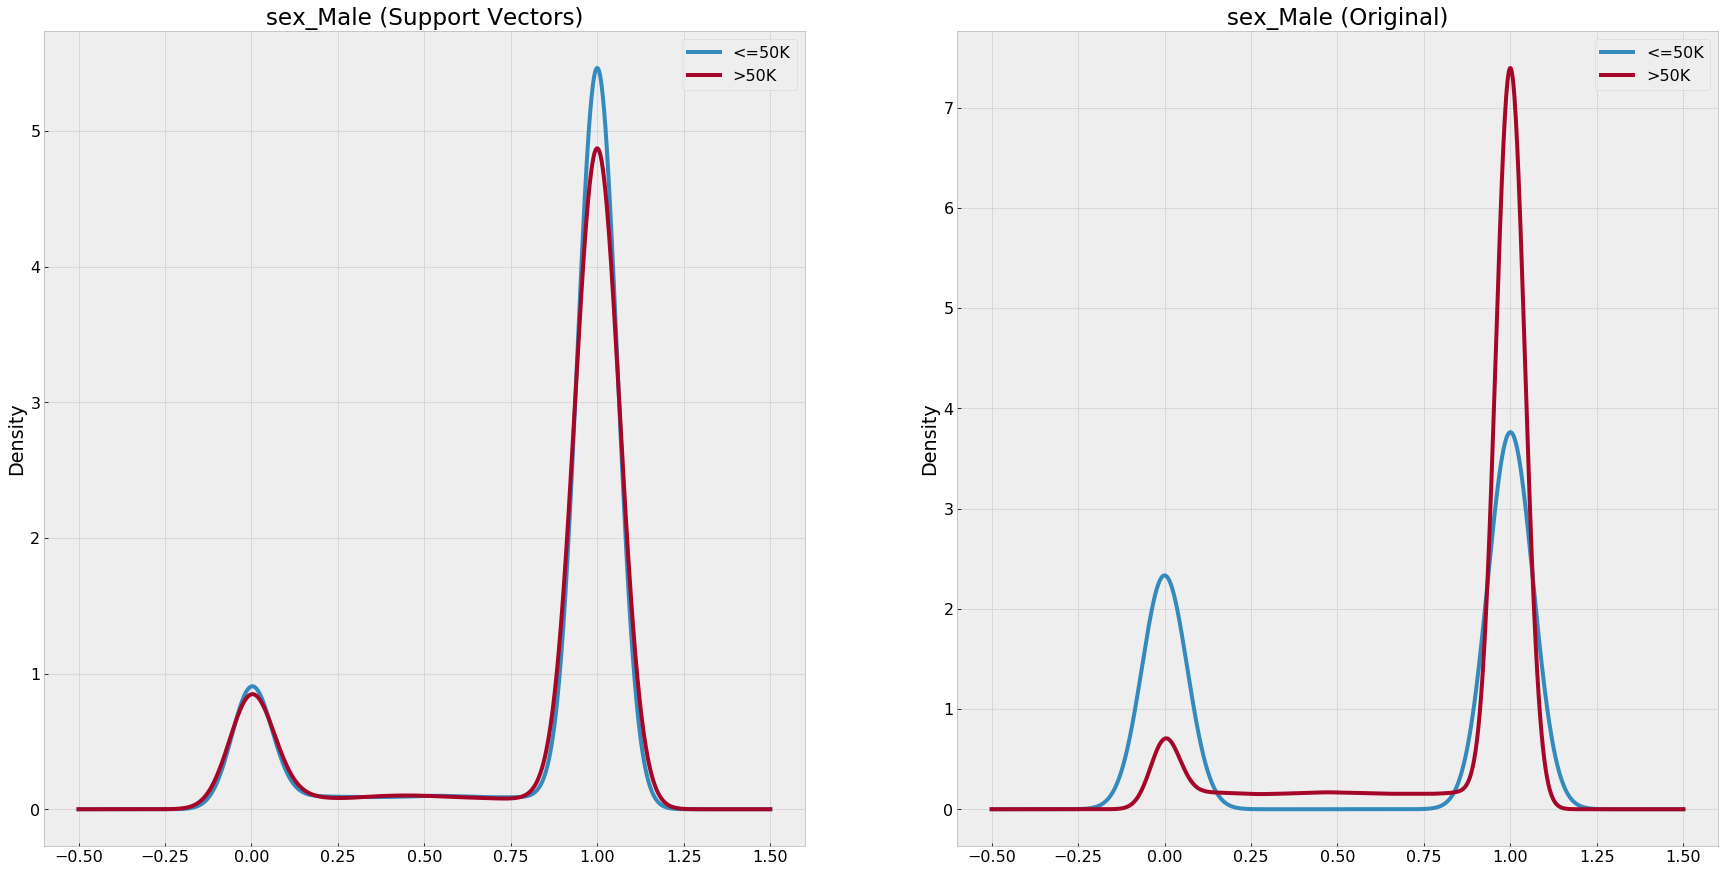

<Figure size 720x288 with 0 Axes>

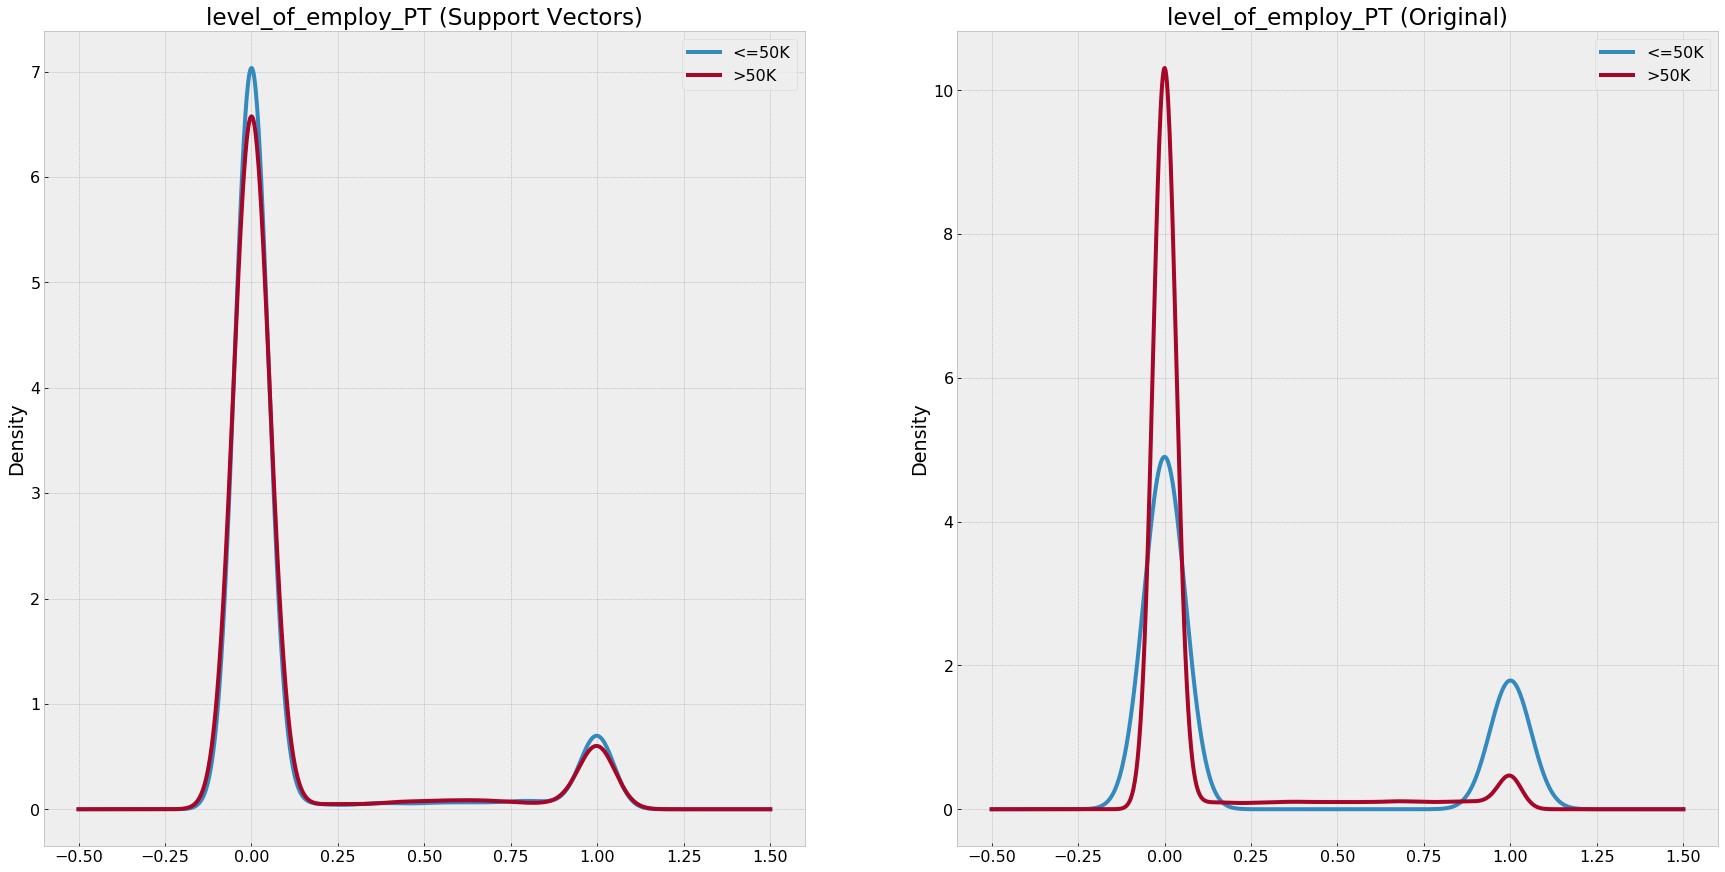

In [42]:
df_grouped_support = df_support.groupby(['income_outcome'])
df_grouped = smote_df_.groupby(['income_outcome'])

# plot KDE of Different variables
vars_to_plot = ['education_num_yr', 'cap_gain', 'age', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'level_of_employ_PT']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.figure(figsize=(30,15))
    plt.rcParams.update({'font.size': 16,'lines.linewidth':4})
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')

In [43]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
log_clf =  LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter=1e6 )
rfe = RFE(estimator=log_clf, n_features_to_select=5, step=1)
rfe.fit( X_train_scaled_smote_,y_train )
ranking = rfe.ranking_
ranks = list(rfe.ranking_)
names_ = list(smote_df_.columns)
names_.remove('income_outcome')
ranking_dict = {'Importance_Ranking' : ranks, "Features" : names_}
important_feat_df = pd.DataFrame(ranking_dict)
important_feat_df.sort_values(by = 'Importance_Ranking').head(n=25)

Importance_Ranking                              Features
0                    1                                   age
5                    1                        hours_per_week
3                    1                              cap_gain
69                   1                marital_stat_Unmarried
2                    1                      education_num_yr
54                   2                              sex_Male
53                   3                     relationship_Wife
51                   4                relationship_Own-child
42                   5              occupation_Other-service
4                    6                              cap_loss
34                   7              marital_status_Separated
27                   8                   education_Preschool
38                   9            occupation_Exec-managerial
68                  10                      age_range_senior
39                  11            occupation_Farming-fishing
43                  12            occupation_Priv-house-serv
60                  13                    level_of_employ_PT
33                  14          marital_status_Never-married
44                  15             occupation_Prof-specialty
32                  16  marital_status_Married-spouse-absent
58                  17                            race_White
56                  18                            race_Black
55                  19               race_Asian-Pac-Islander
12                  20            workclass_Self-emp-not-inc
28                  21                 education_Prof-school

In [44]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
log_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter=1e6 )
rfecv = RFECV(estimator=log_clf, step=1, cv=cv_object, min_features_to_select = 5 )
rfecv.fit(X_train_scaled_smote_, y_train)
ranking = rfecv.ranking_
ranks = list(rfecv.ranking_)
names_ = list(smote_df_.columns)
names_.remove('income_outcome')
ranking_dict = {'Importance_Ranking' : ranks, "Features" : names_}
important_feat_df = pd.DataFrame(ranking_dict)
important_feat_df.sort_values(by = 'Importance_Ranking').head(n=25)


Importance_Ranking                              Features
0                    1                                   age
33                   1          marital_status_Never-married
68                   1                      age_range_senior
38                   1            occupation_Exec-managerial
39                   1            occupation_Farming-fishing
40                   1          occupation_Handlers-cleaners
42                   1              occupation_Other-service
43                   1            occupation_Priv-house-serv
44                   1             occupation_Prof-specialty
45                   1            occupation_Protective-serv
46                   1                      occupation_Sales
47                   1               occupation_Tech-support
32                   1  marital_status_Married-spouse-absent
50                   1           relationship_Other-relative
53                   1                     relationship_Wife
54                   1                              sex_Male
55                   1               race_Asian-Pac-Islander
56                   1                            race_Black
58                   1                            race_White
60                   1                    level_of_employ_PT
61                   1                 education_level_CGRAD
62                   1                    education_level_HS
64                   1                 education_level_PGRAD
65                   1                  education_level_PRIM
67                   1                       age_range_child

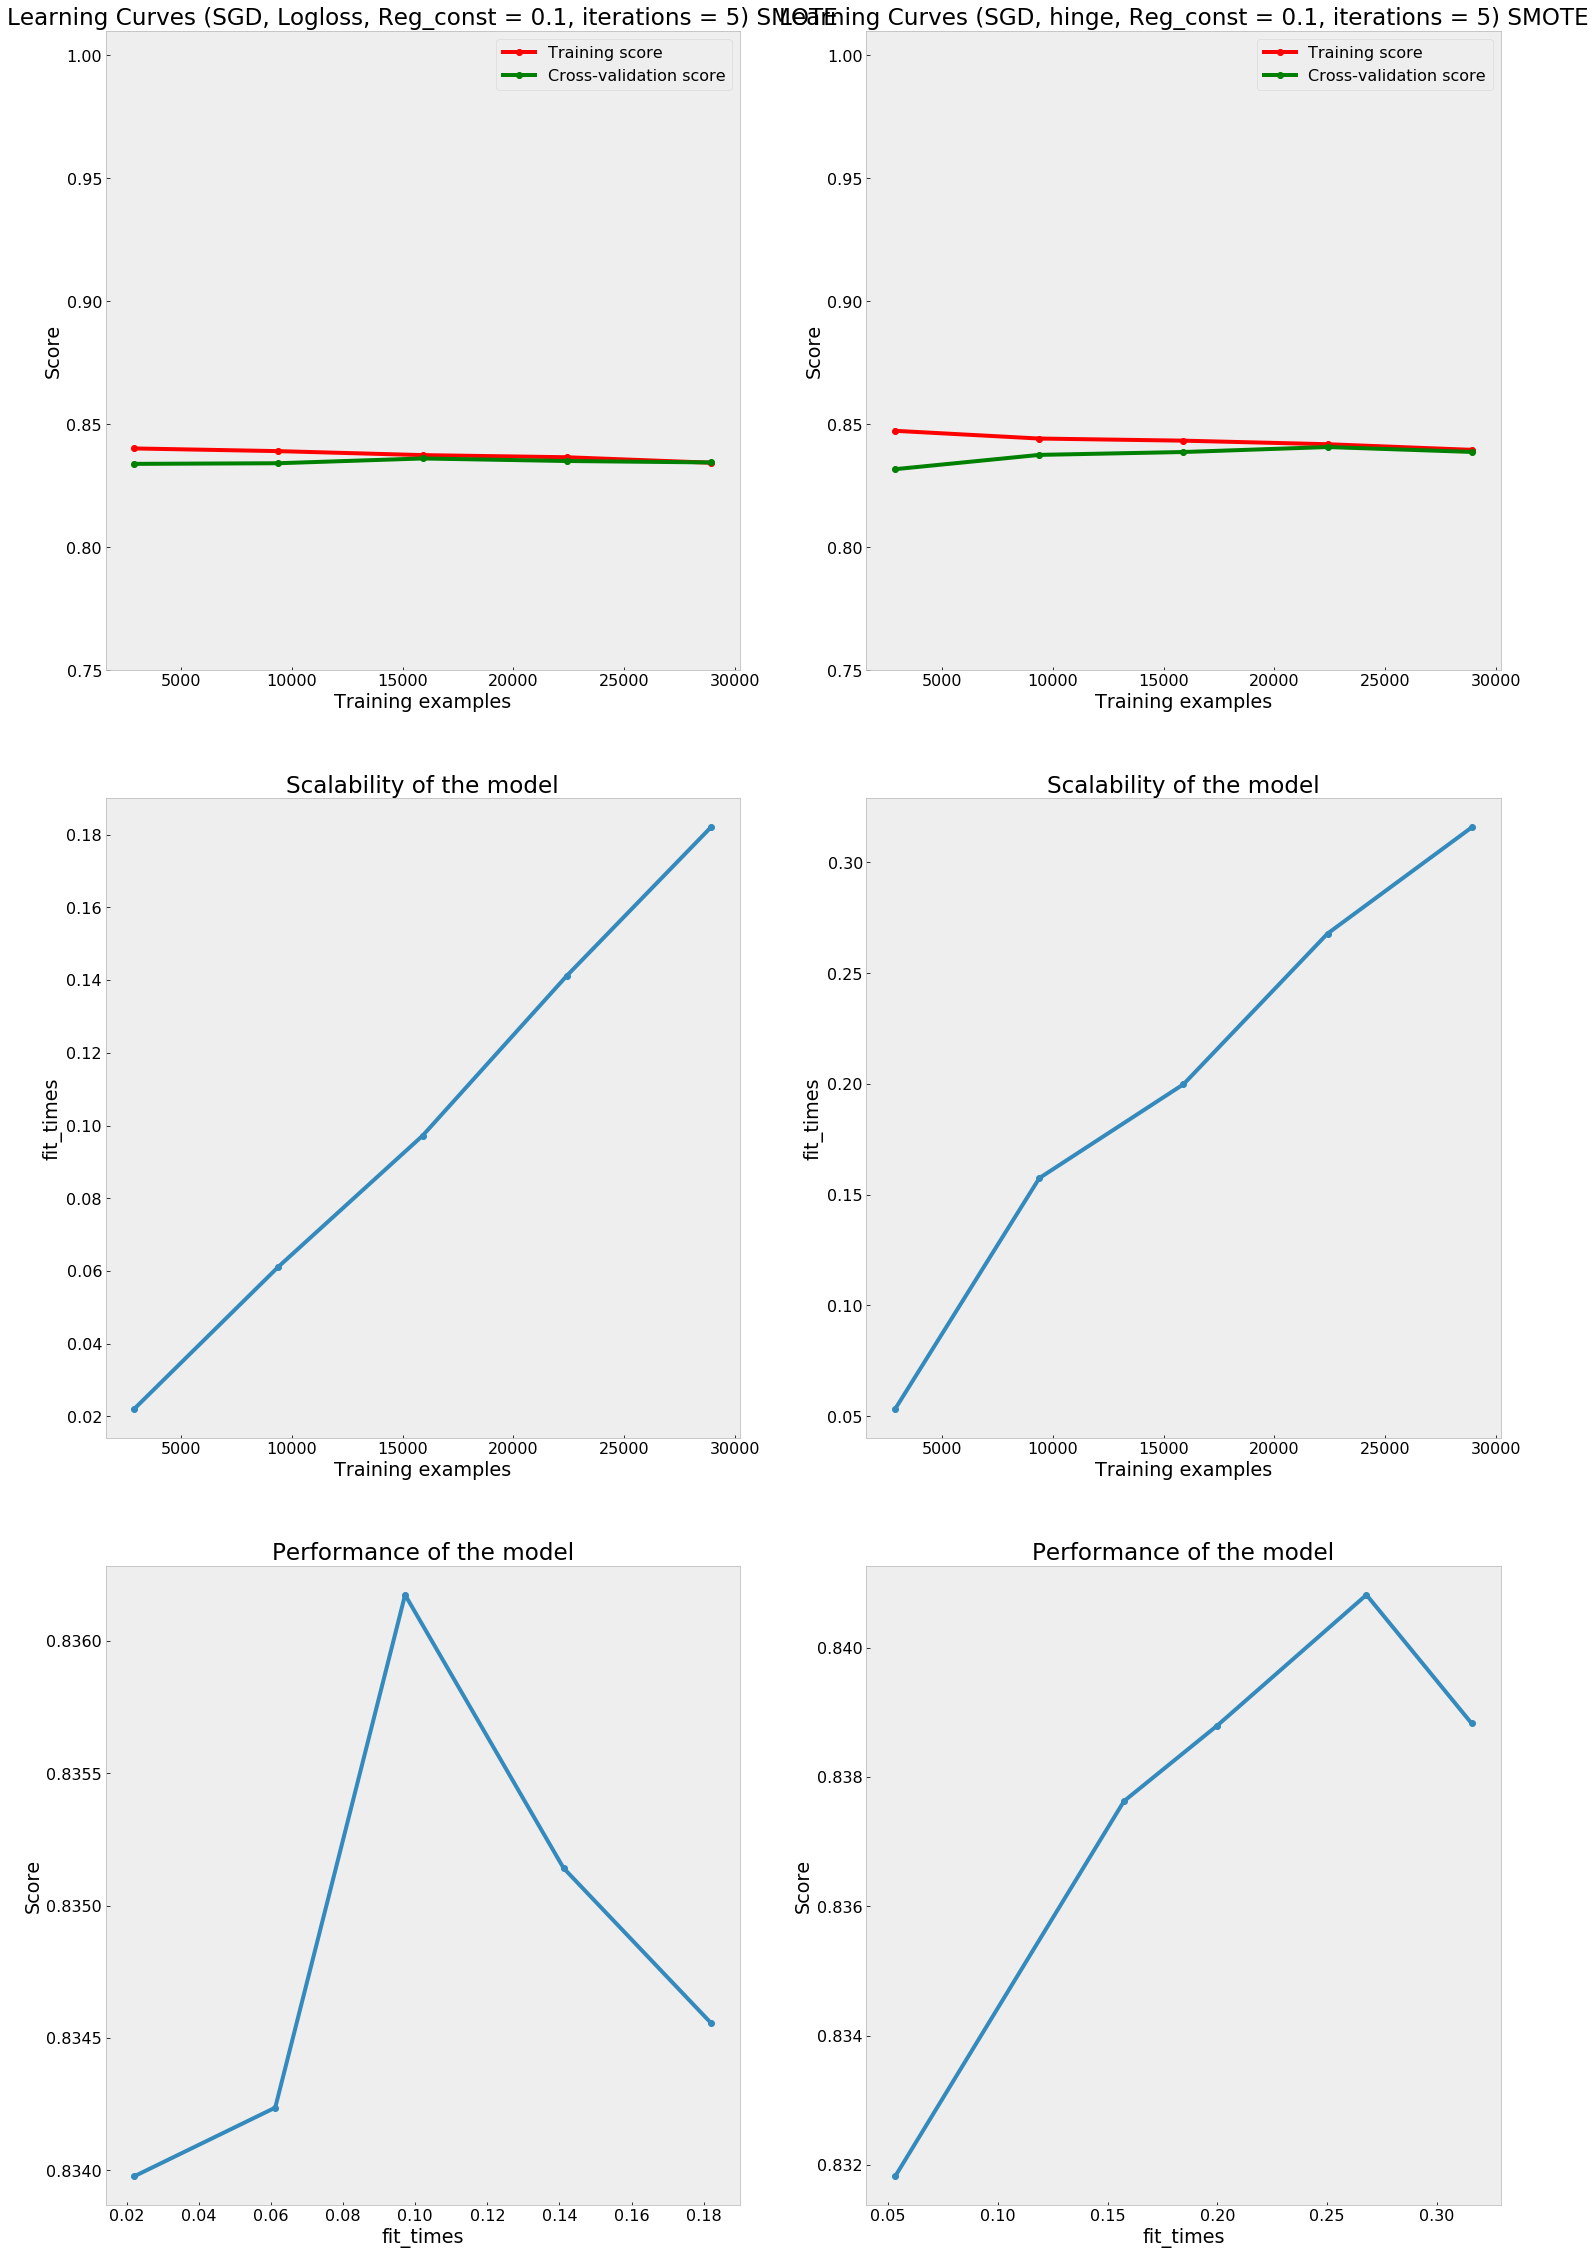

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(25, 40))

title = r"Learning Curves (SGD, Logloss, Reg_const = 0.1, iterations = 5) SMOTE"
# SVC is more expensive so we do a lower number of CV iterations:




regularize_const = 0.1
iterations = 10
estimator = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', max_iter=1e6)

plot_learning_curve(estimator, title, X_train_scaled_smote_, y_train, axes=axes[:, 0], ylim=(0.75, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')





title = r"Learning Curves (SGD, hinge, Reg_const = 0.1, iterations = 5) SMOTE"





regularize_const = 0.001
iterations = 10
estimator = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', max_iter=1e6)

plot_learning_curve(estimator, title, X_train_scaled_smote_, y_train, axes=axes[:, 1], ylim=(0.75, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')

plt.show()

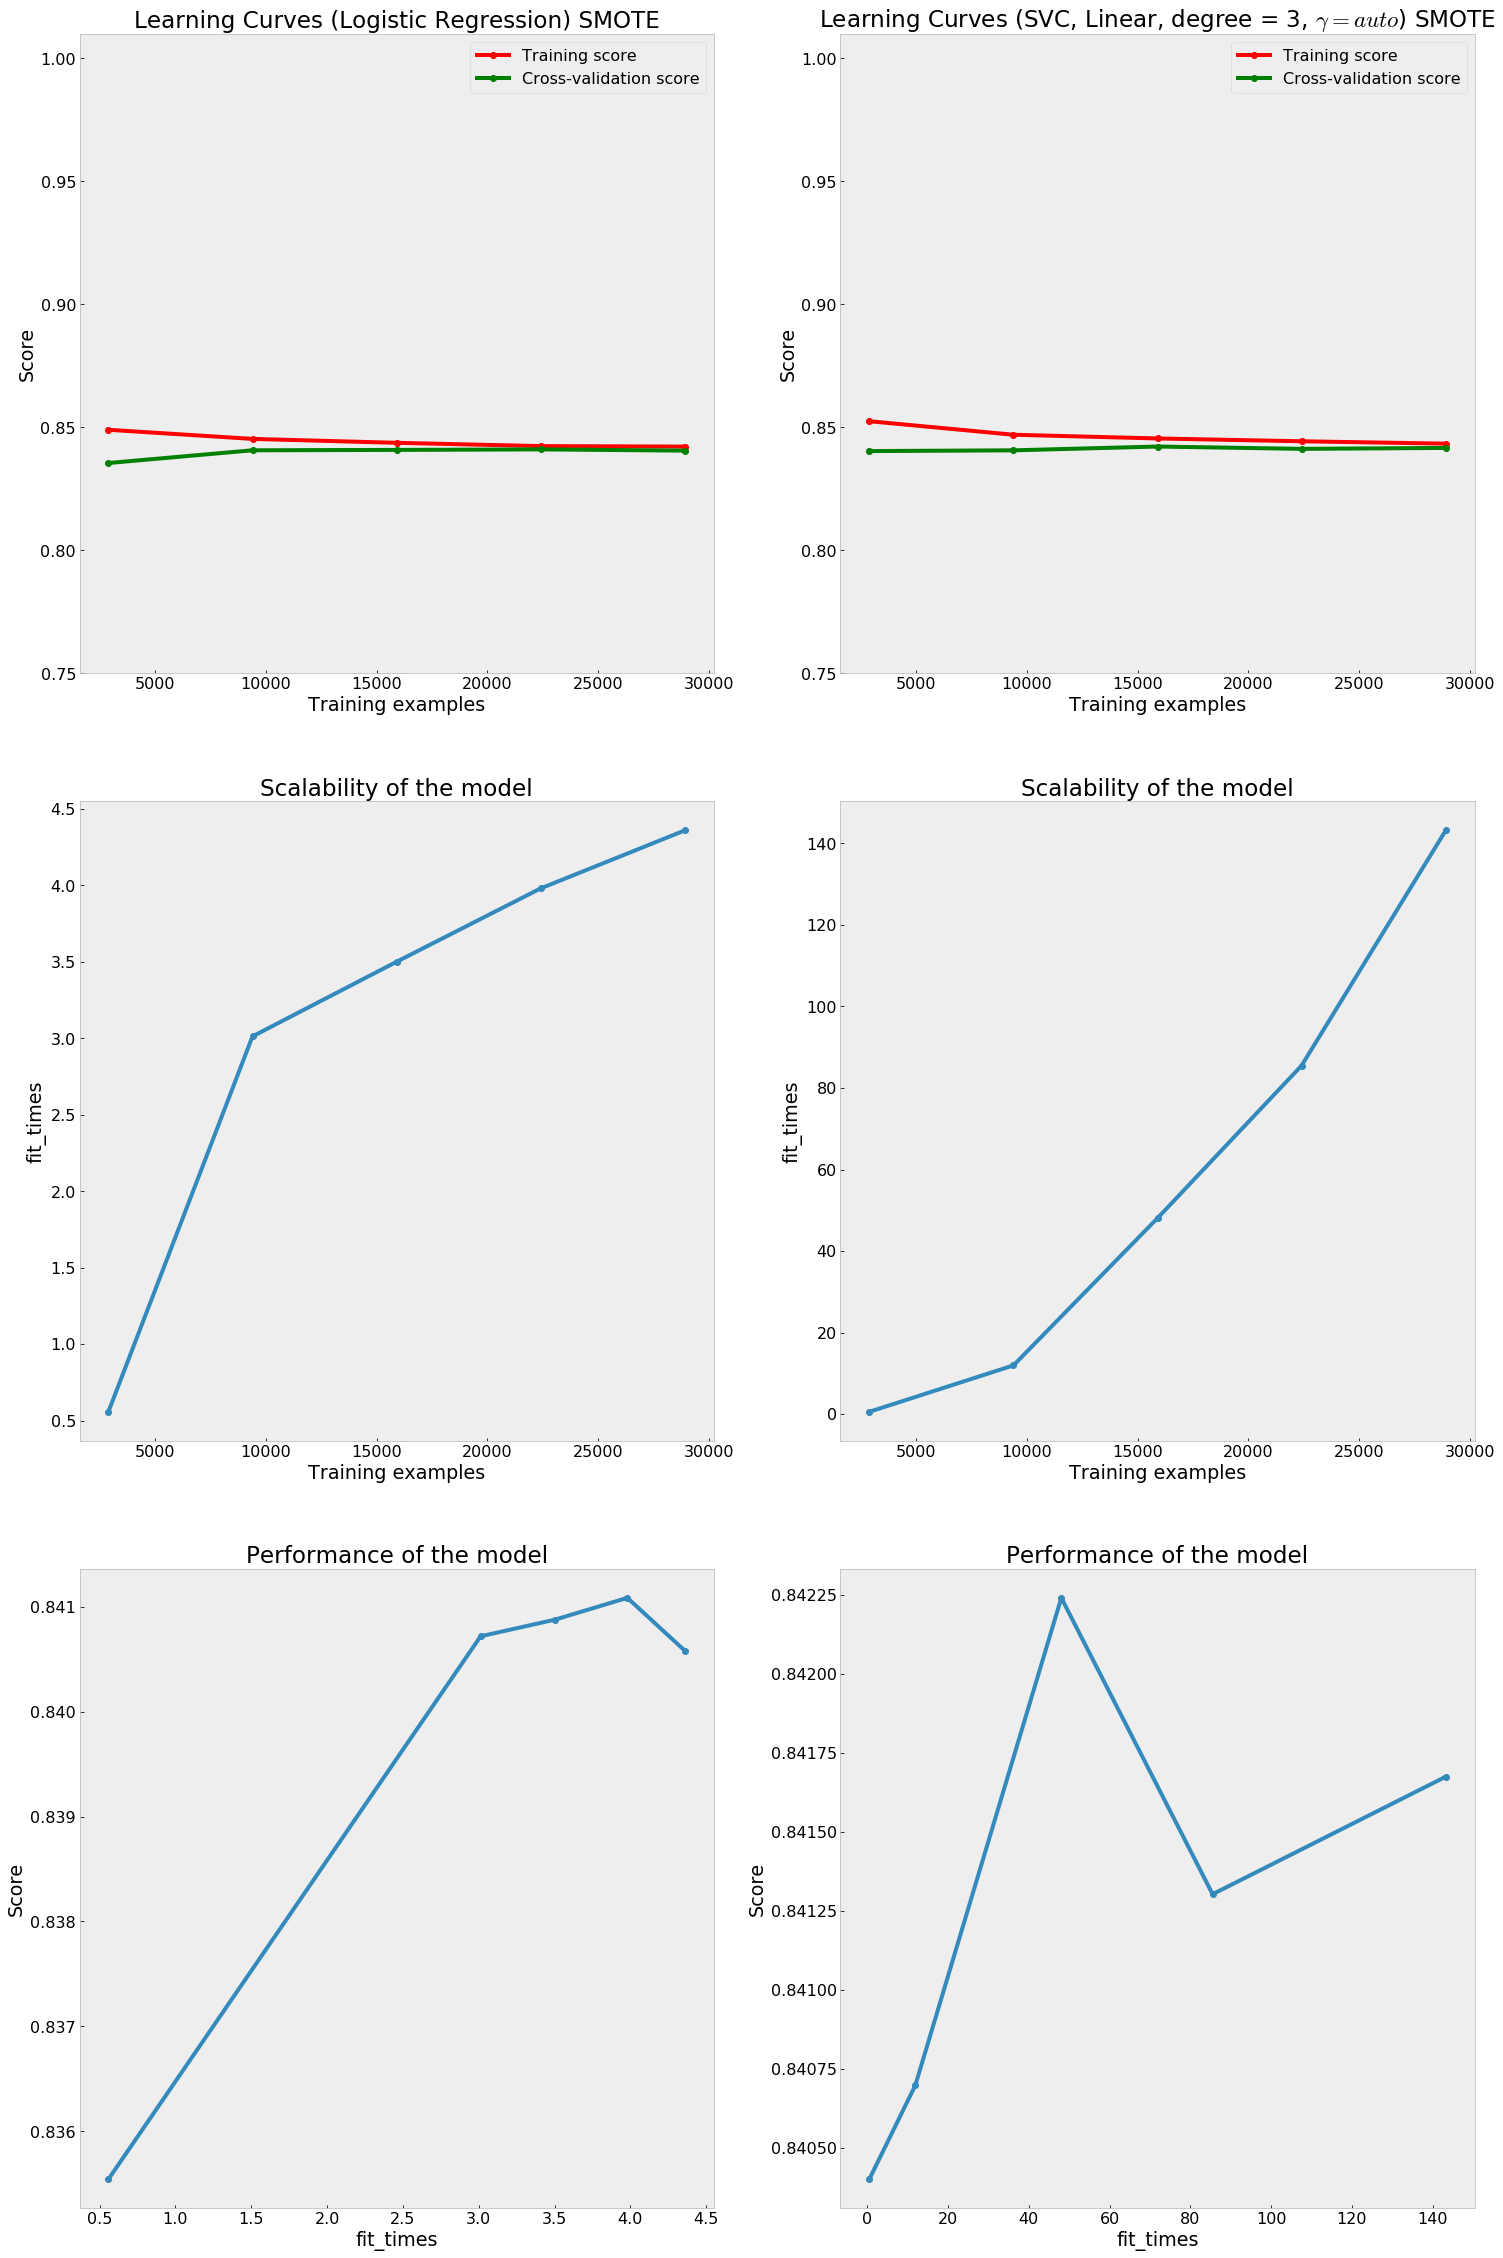

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(25, 40))

title = r"Learning Curves (Logistic Regression) SMOTE"
# SVC is more expensive so we do a lower number of CV iterations:

estimator = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter = 1e6)

plot_learning_curve(estimator, title, X_train_scaled_smote_, y_train, axes=axes[:, 0], ylim=(0.75, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')


title = r"Learning Curves (SVC, Linear, degree = 3, $\gamma=auto$) SMOTE"


estimator = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')

plot_learning_curve(estimator, title, X_train_scaled_smote_, y_train, axes=axes[:, 1], ylim=(0.75, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')

plt.show()

End SMOTE SAMPLING 

SVC Models

In [47]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4




svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)): 
    
    ML_std_clf.fit(X[train_indices])
    X_train_scaled = ML_std_clf.transform(X[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X[test_indices]) 
    
    t = time.process_time()
    svm_clf.fit(X_train_scaled, y[train_indices])  # train object

    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
    
    elapsed_time = time.process_time() - t
    
    acc = mt.accuracy_score(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num += 1
    
    

====Iteration 0  ====

Accuracy:  0.8440565253532835 

f1_score: 0.6543846720707444 

precision_score: 0.7302631578947368 

roc_auc_score: 0.7600879099961487 

Confusion Matrix: 

      0    1
0  4189  328
1   610  888 

Train Time:  39.58721814199998 s

====Iteration 1  ====

Accuracy:  0.8453865336658354 

f1_score: 0.6516853932584269 

precision_score: 0.742320819112628 

roc_auc_score: 0.7569579156977955 

Confusion Matrix: 

      0    1
0  4215  302
1   628  870 

Train Time:  39.676869834999934 s

====Iteration 2  ====

Accuracy:  0.8465502909393183 

f1_score: 0.65130336229694 

precision_score: 0.7502175805047868 

roc_auc_score: 0.7559480827953617 

Confusion Matrix: 

      0    1
0  4230  287
1   636  862 

Train Time:  37.98614049599996 s



In [48]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
for (train_indices, test_indices) in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    ML_std_clf.fit(X_train)
    X_train_scaled = ML_std_clf.transform(X_train) 
    X_test_scaled = ML_std_clf.transform(X_test) 

In [49]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
#https://docs.python.org/3/library/time.html#functions


# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') 
t = time.process_time()
svm_clf.fit(X_train_scaled, y_train)  

y_hat = svm_clf.predict(X_test_scaled) 

elapsed_time = time.process_time() - t


acc = mt.accuracy_score(y_test,y_hat)
f1_scor_ = mt.f1_score(y_test,y_hat)
prec_scor_ = mt.precision_score(y_test, y_hat)
auc_scor_ = mt.roc_auc_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)


print("Accuracy: ", acc, "\n" )
print("f1_score:", f1_scor_, "\n")
print("precision_score:",prec_scor_ , "\n")
print("roc_auc_score:",auc_scor_ , "\n")
print("Confusion Matrix: \n")
print (pd.DataFrame(conf),"\n")
print("Train Time: ", elapsed_time,  "s\n")





Accuracy:  0.8465502909393183 

f1_score: 0.65130336229694 

precision_score: 0.7502175805047868 

roc_auc_score: 0.7559480827953617 

Confusion Matrix: 

      0    1
0  4230  287
1   636  862 

Train Time:  38.52850899300006 s



In [50]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(8334, 70)
(8334,)
[4176 4158]


[[ 2.33879608e-01  5.13666903e-02  1.45875159e-01  1.87371538e+00
   1.93776901e-01  1.23122303e-01  1.85585152e-02 -7.48267811e-02
   1.18147728e-01 -1.00320786e-01 -1.22350855e-01  1.76039011e-02
  -1.55362346e-01 -9.37245761e-02 -1.45582692e-02  1.21765701e-02
  -1.26448686e-02  3.53544072e-02  3.70441181e-02 -2.90130063e-02
  -1.71623091e-02 -2.17869642e-02 -3.50860086e-02  7.83679851e-02
   4.91224246e-02 -4.00580838e-02  4.50363295e-02 -3.00154293e-01
   1.09541458e-01 -1.82631316e-02  2.04536551e-02  2.60601306e-01
  -5.02497298e-02 -1.06157320e-01 -7.17513712e-02  5.92137584e-02
   3.55271368e-15 -2.89817142e-02  2.46892643e-01 -8.96505324e-02
  -5.20024348e-02 -5.02131047e-02 -1.07913527e-01 -7.81406902e-02
   1.70379710e-01  5.96897933e-02  6.26749661e-02  1.14864058e-01
  -3.33849488e-02 -1.59505921e-01 -6.64011476e-02 -2.42415979e-01
  -1.07360792e-01  1.41734796e-01  1.99707478e-01  6.80321234e-02
   7.47106298e-02 -3.07335926e-03  1.11544492e-01  1.85585152e-02
  -1.25616

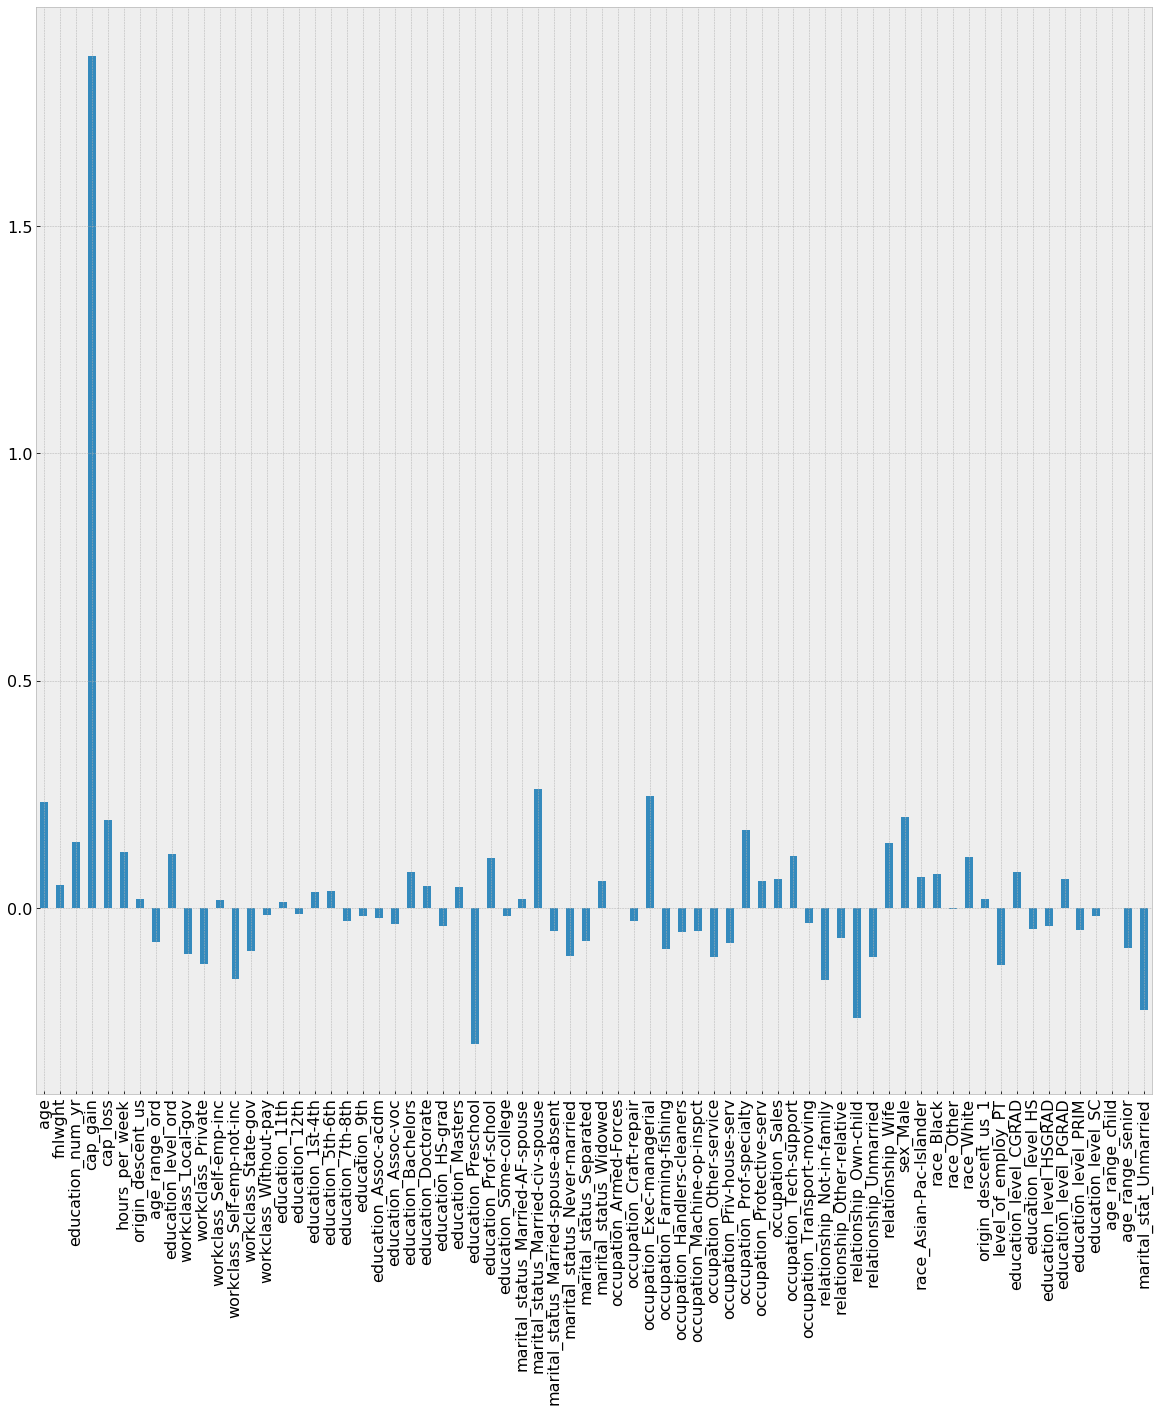

In [51]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=ml_df.columns)
weights.plot(kind='bar',figsize=(20,20), fontsize=16)

In [52]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

df_tested_on = ml_df.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['income_outcome'] = y[svm_clf.support_] # add back in the income_outcomw Column to the pandas support vectors dataframe
ml_df['income_outcome'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8334 entries, 14195 to 20518
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   8334 non-null   int64           
 1   fnlwght                               8334 non-null   int64           
 2   education_num_yr                      8334 non-null   int64           
 3   cap_gain                              8334 non-null   int64           
 4   cap_loss                              8334 non-null   int64           
 5   hours_per_week                        8334 non-null   int64           
 6   origin_descent_us                     8334 non-null   int64           
 7   age_range_ord                         8334 non-null   int64           
 8   education_level_ord                   8334 non-null   int64           
 9   workclass_Local-gov                   8334 non-

<Figure size 720x288 with 0 Axes>

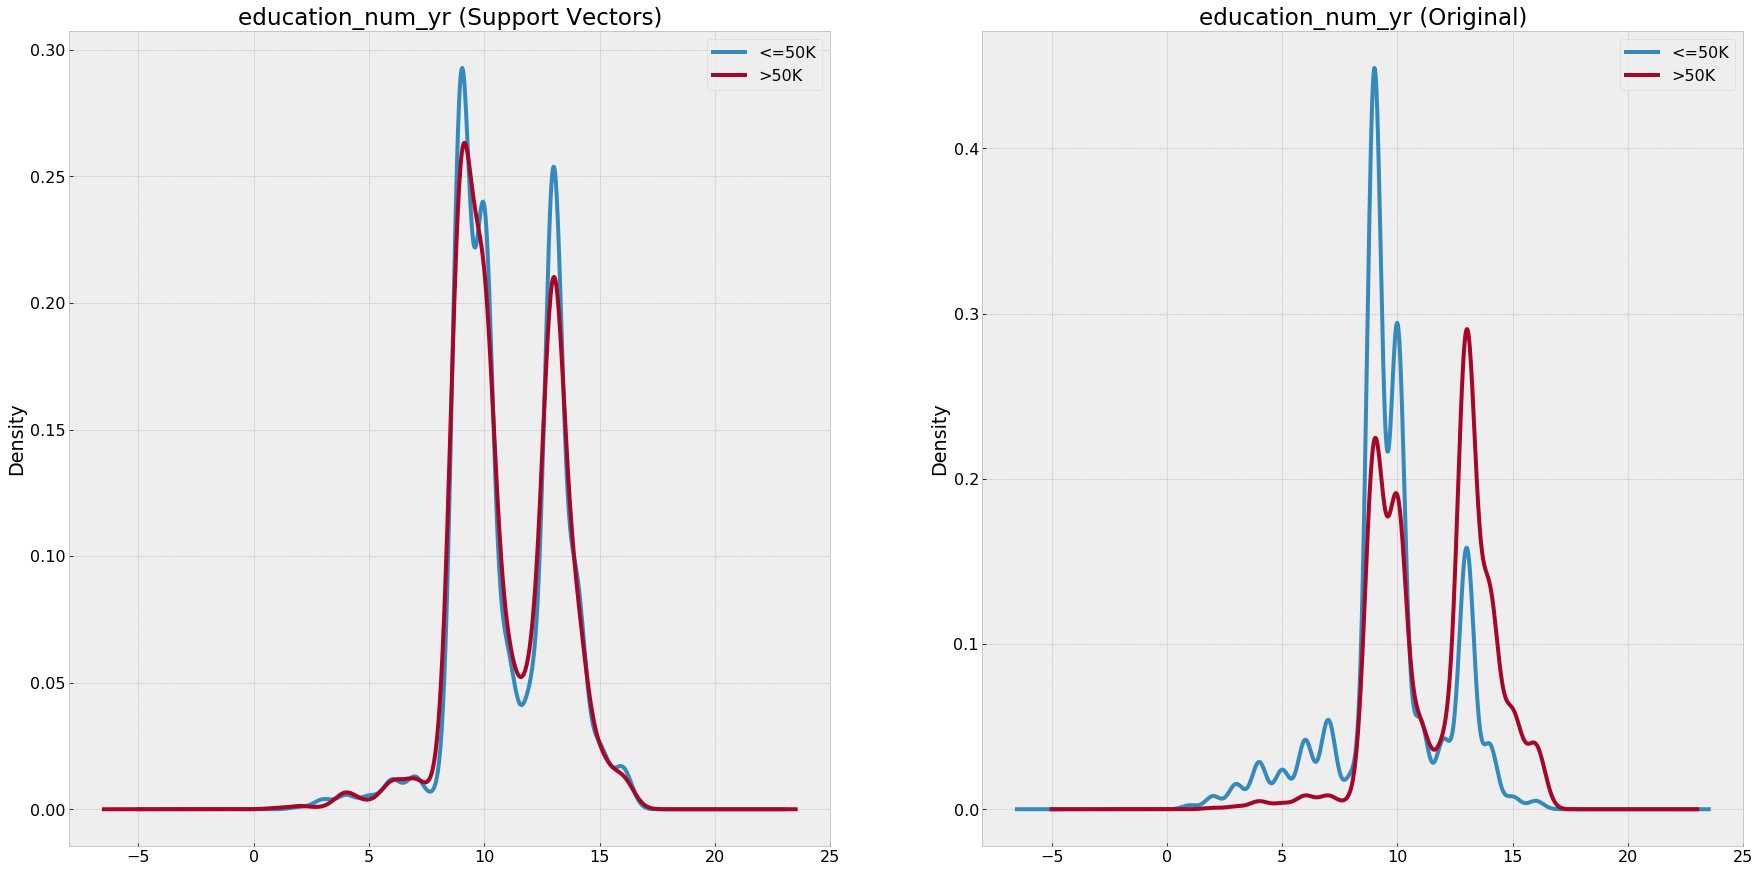

<Figure size 720x288 with 0 Axes>

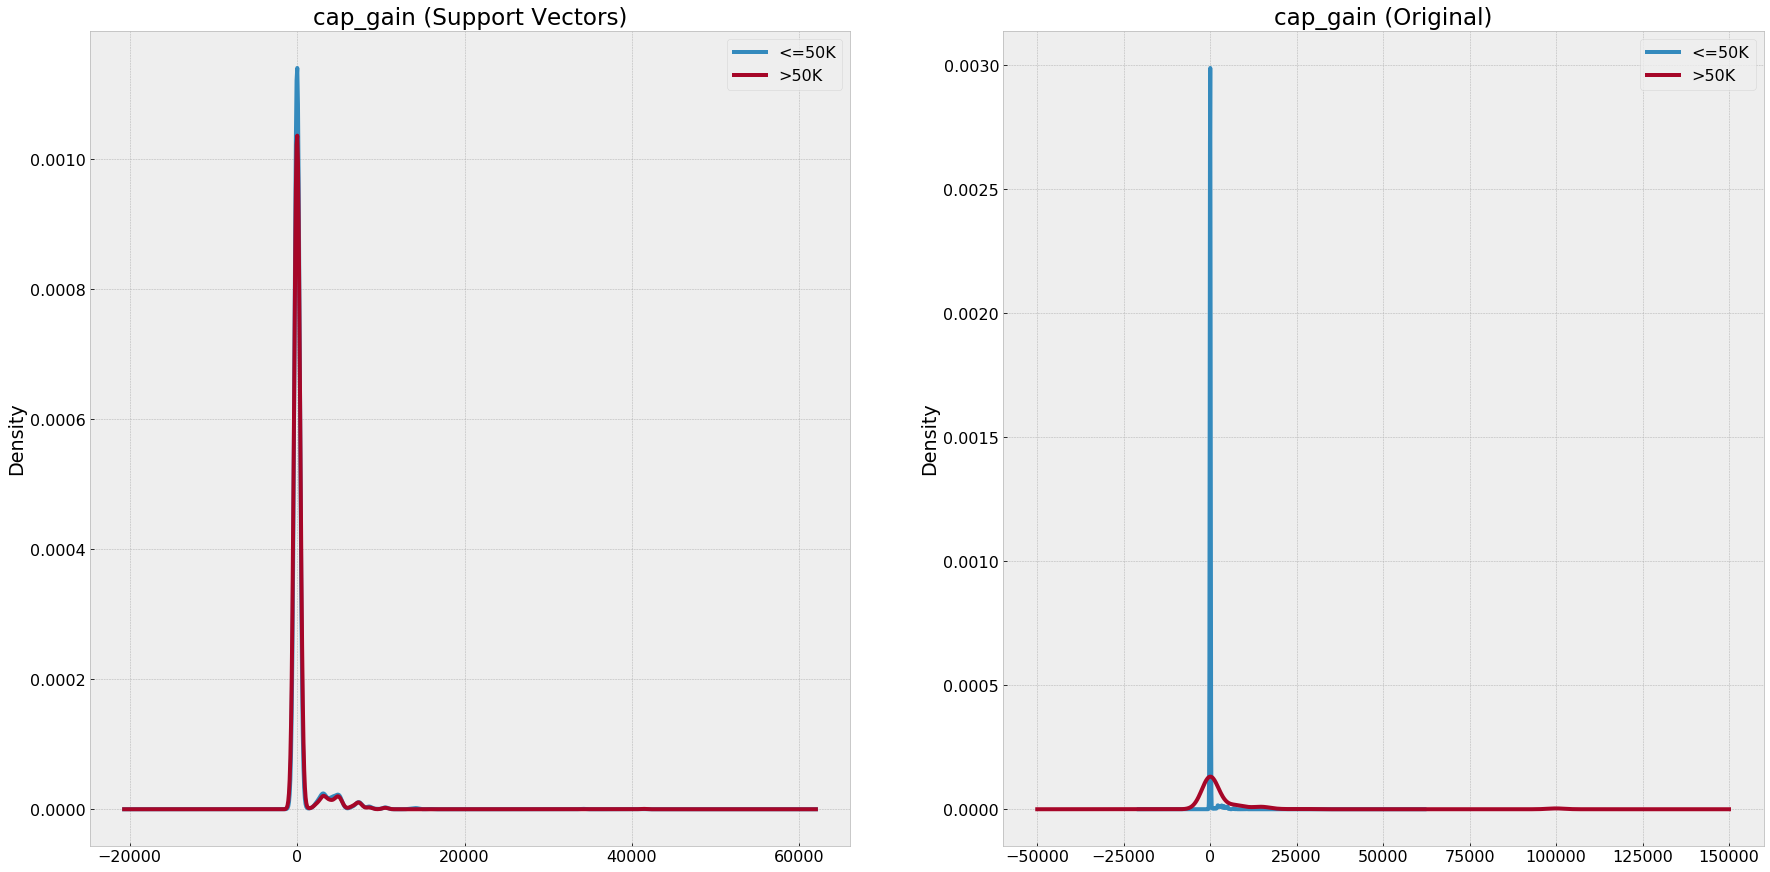

<Figure size 720x288 with 0 Axes>

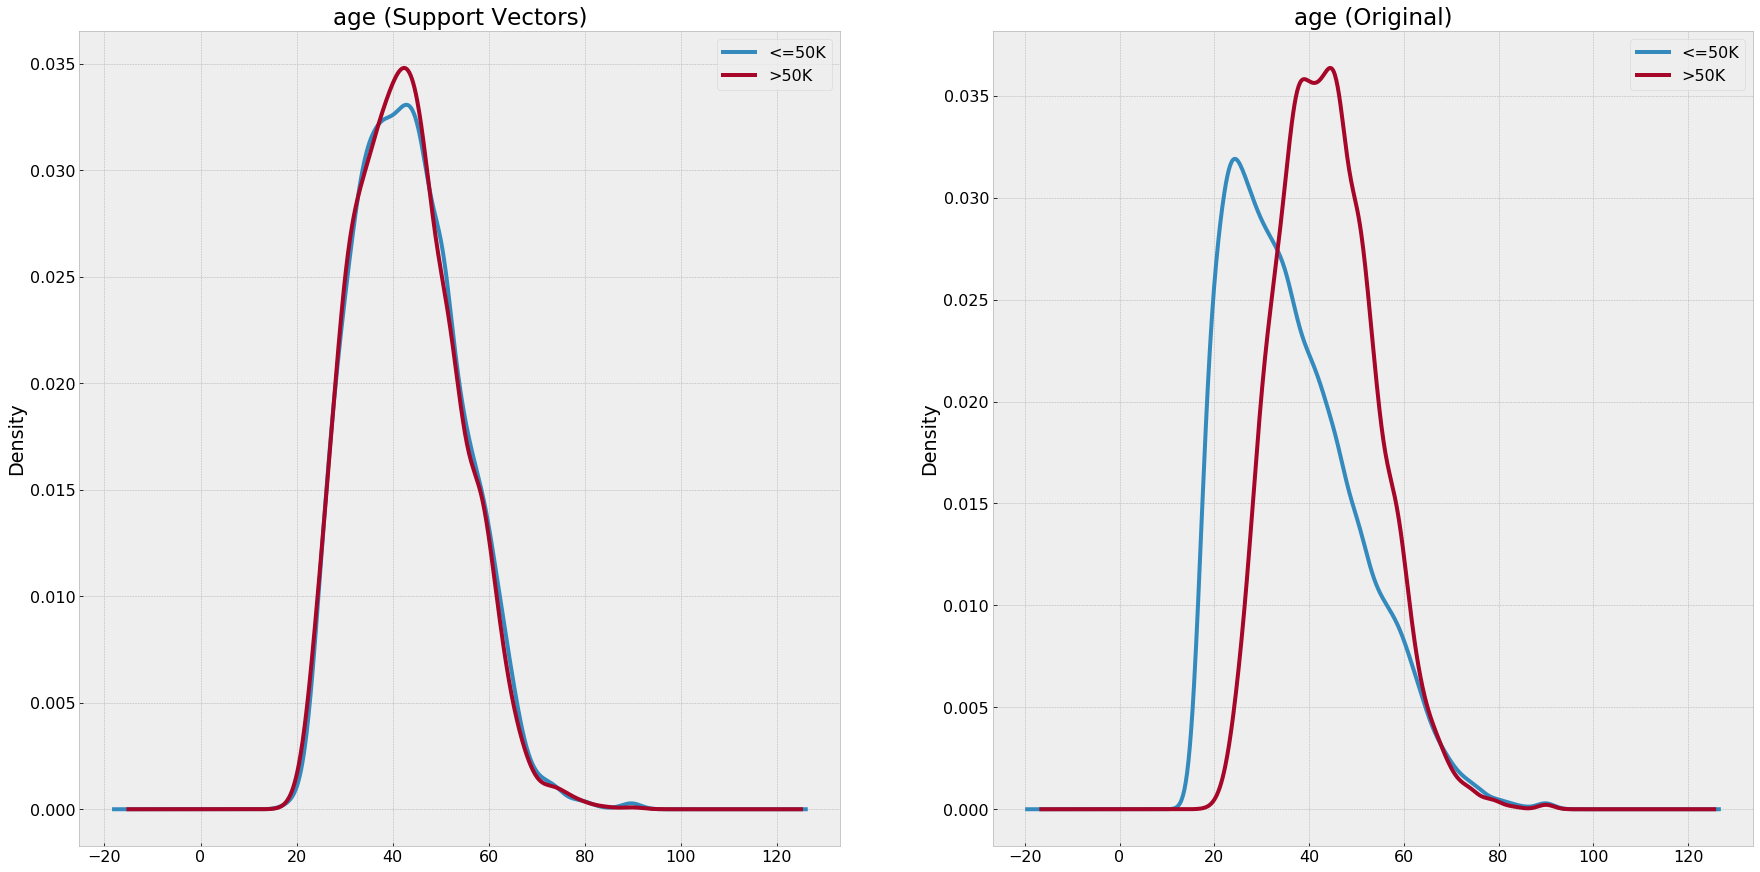

<Figure size 720x288 with 0 Axes>

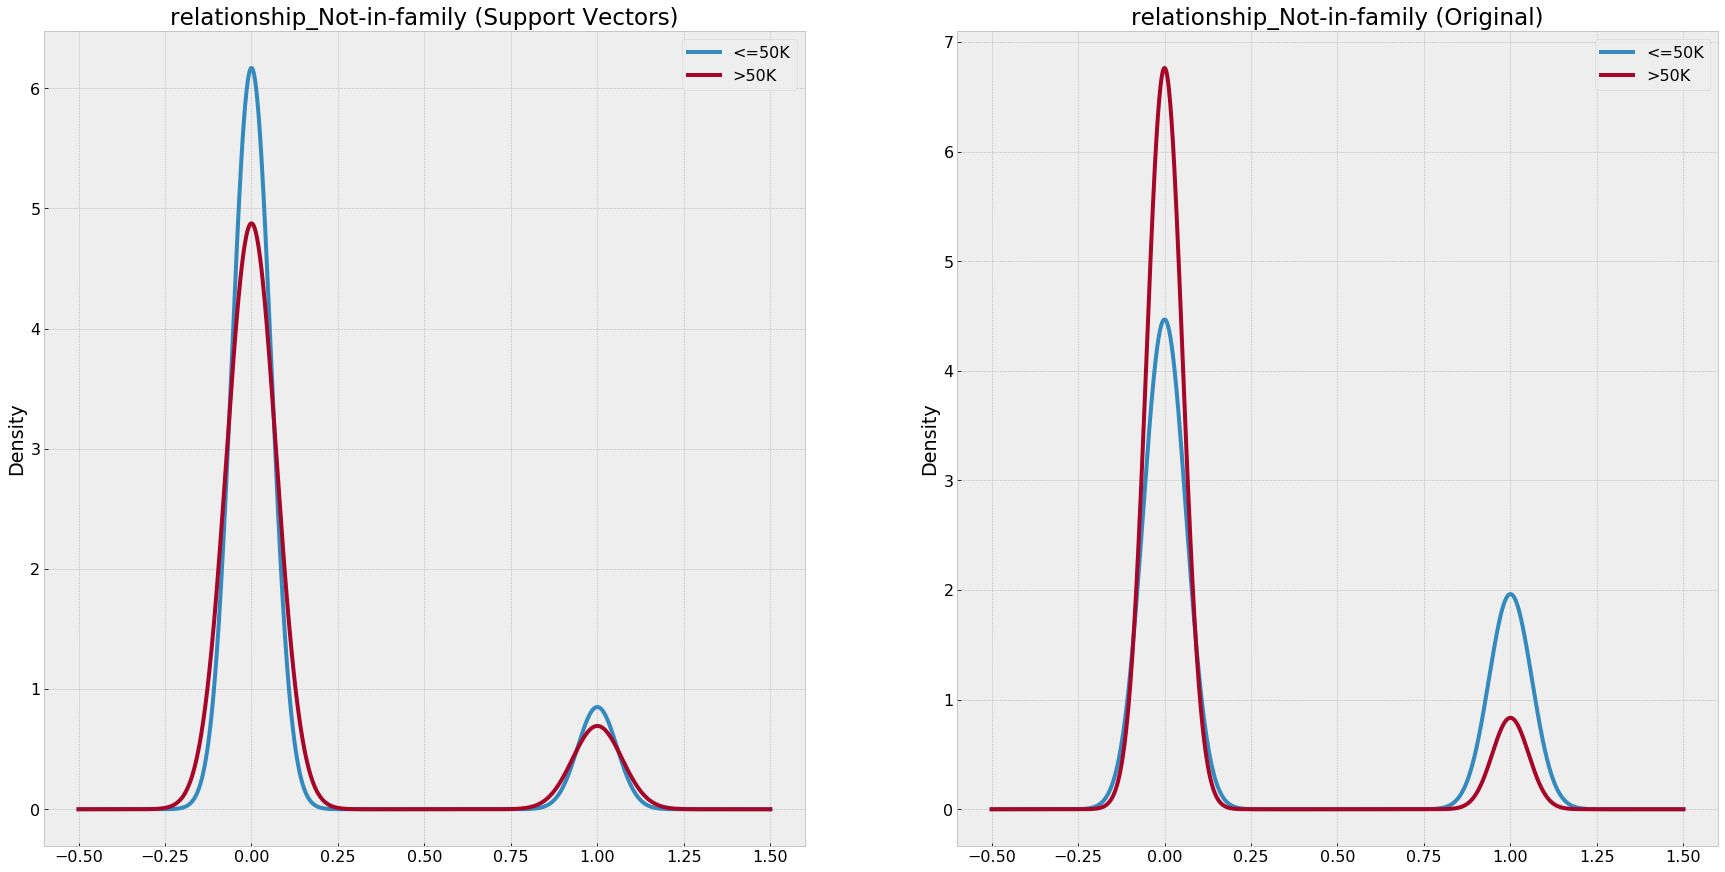

<Figure size 720x288 with 0 Axes>

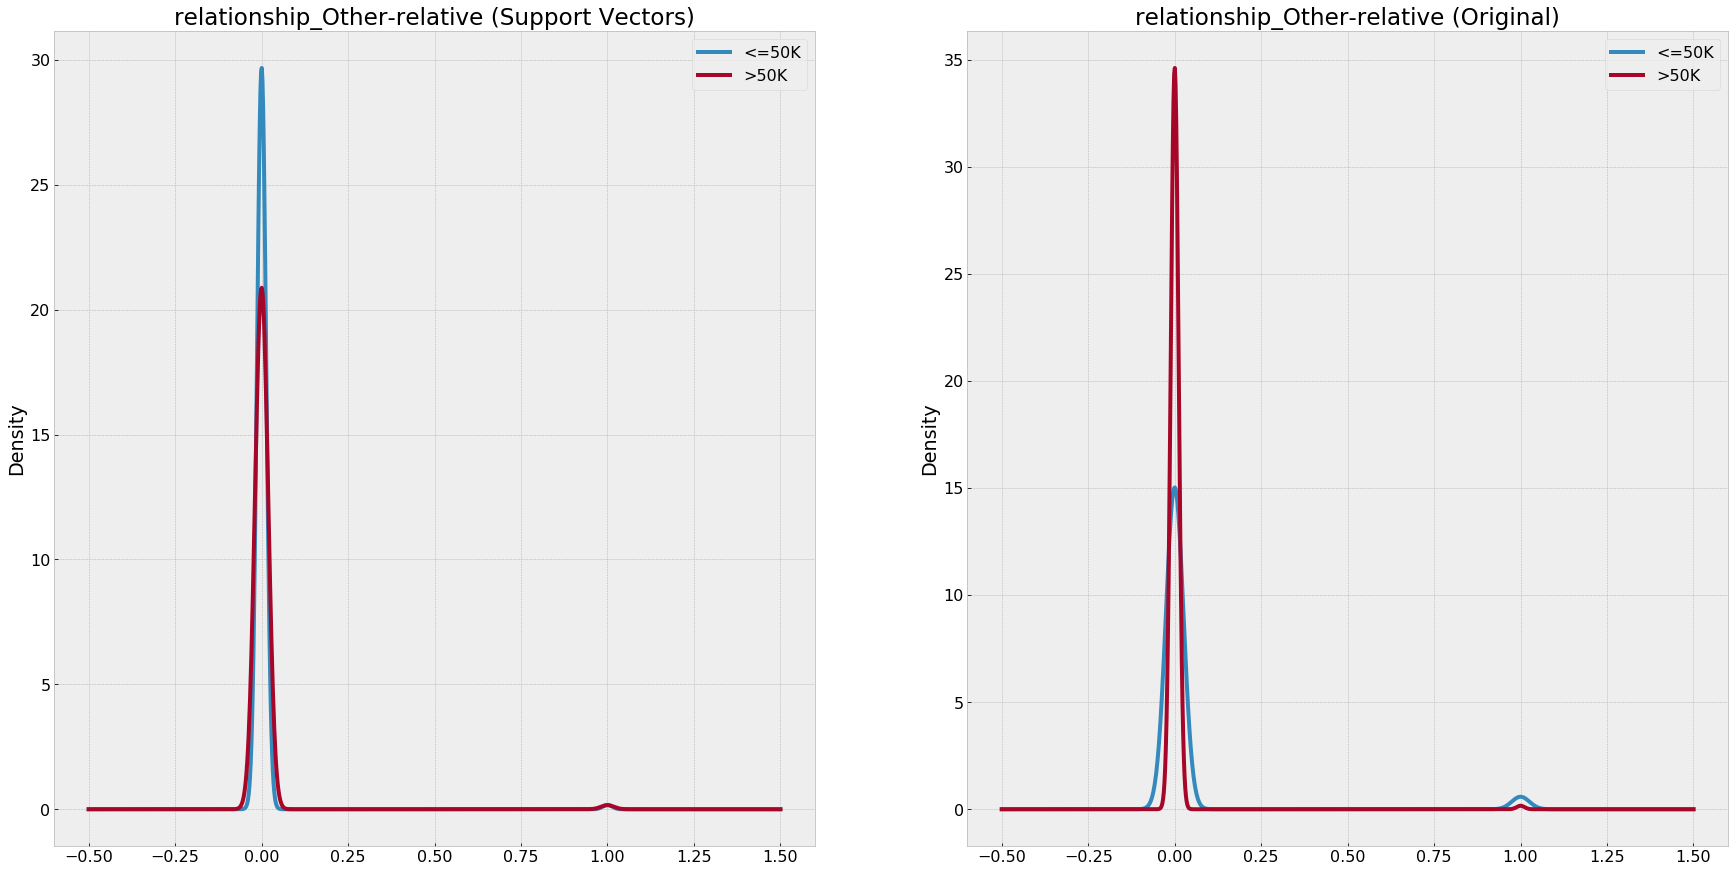

<Figure size 720x288 with 0 Axes>

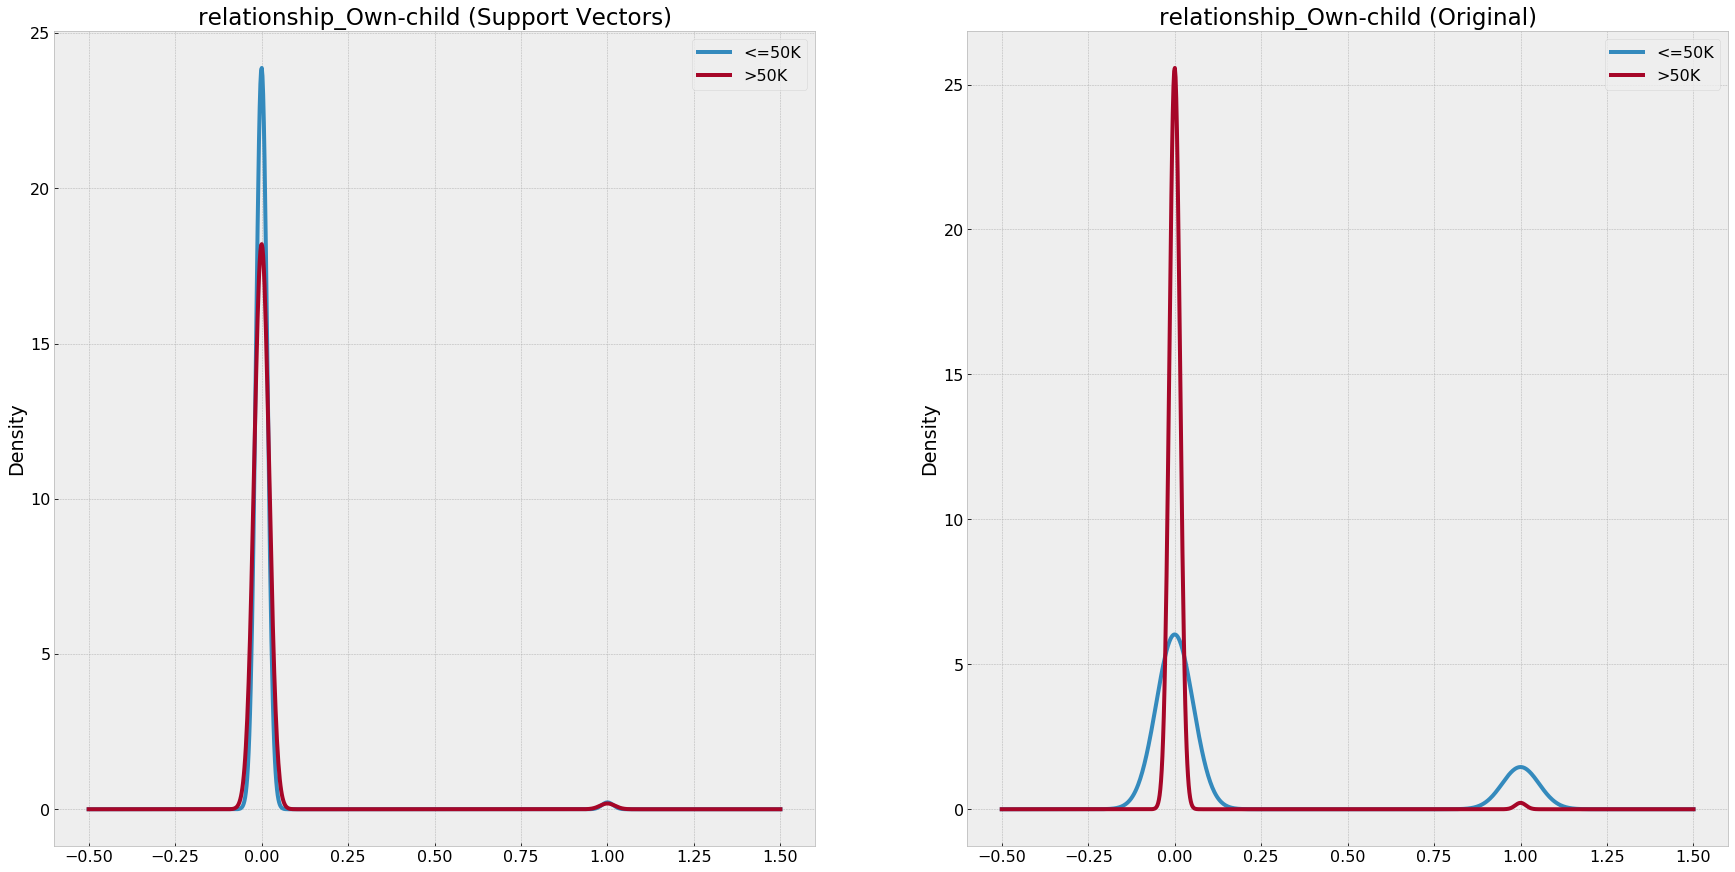

<Figure size 720x288 with 0 Axes>

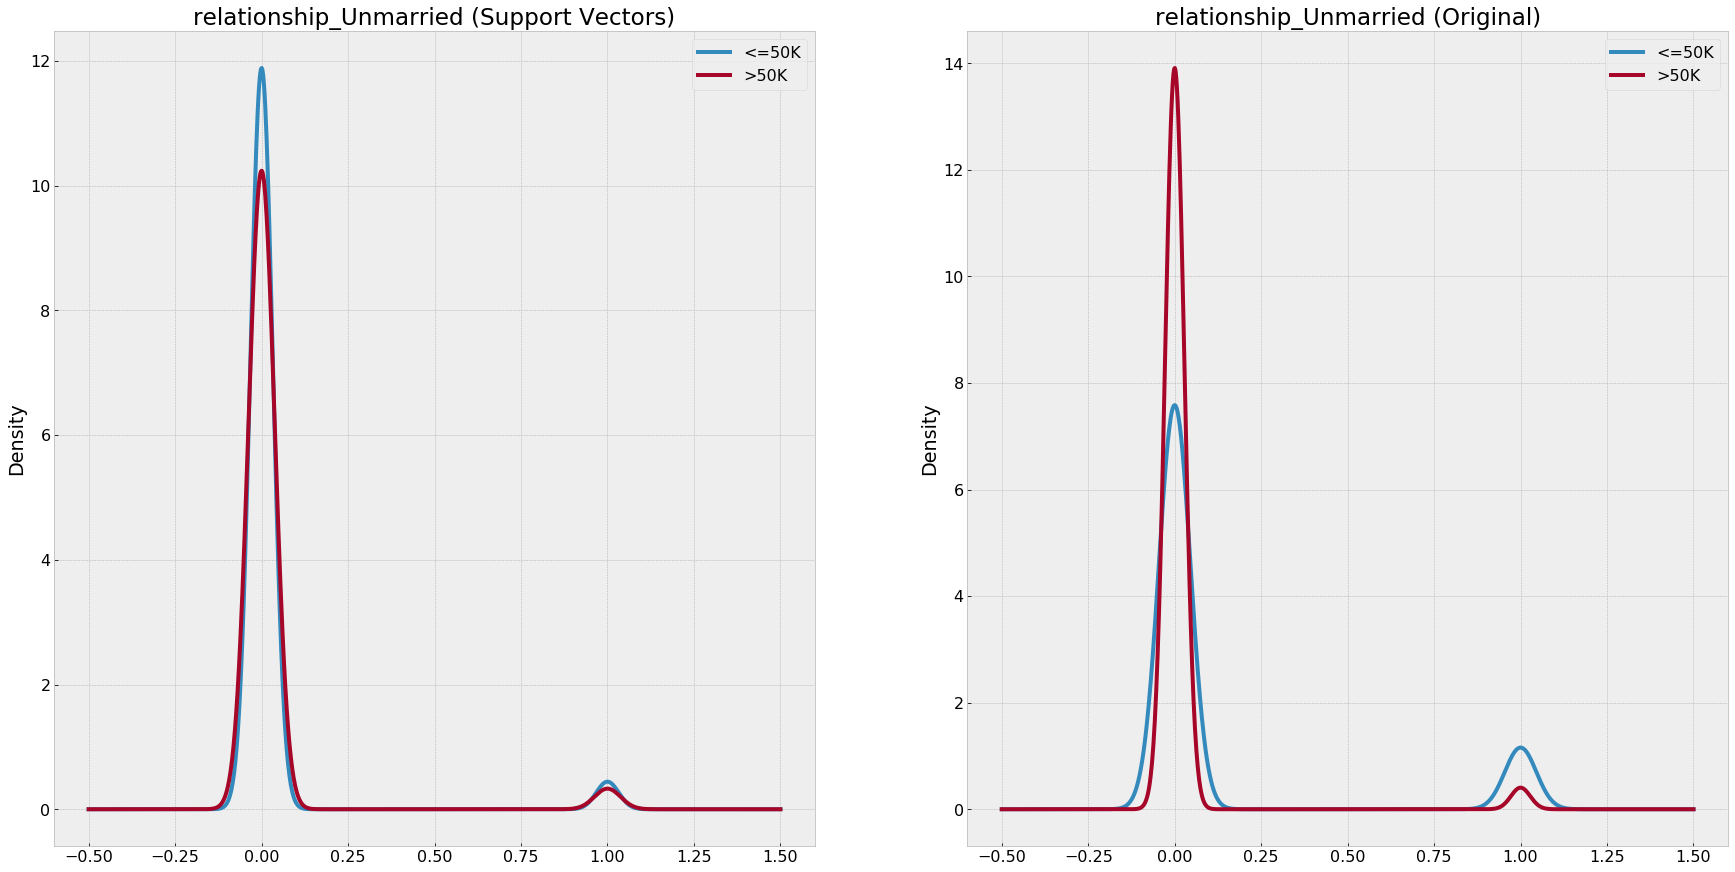

<Figure size 720x288 with 0 Axes>

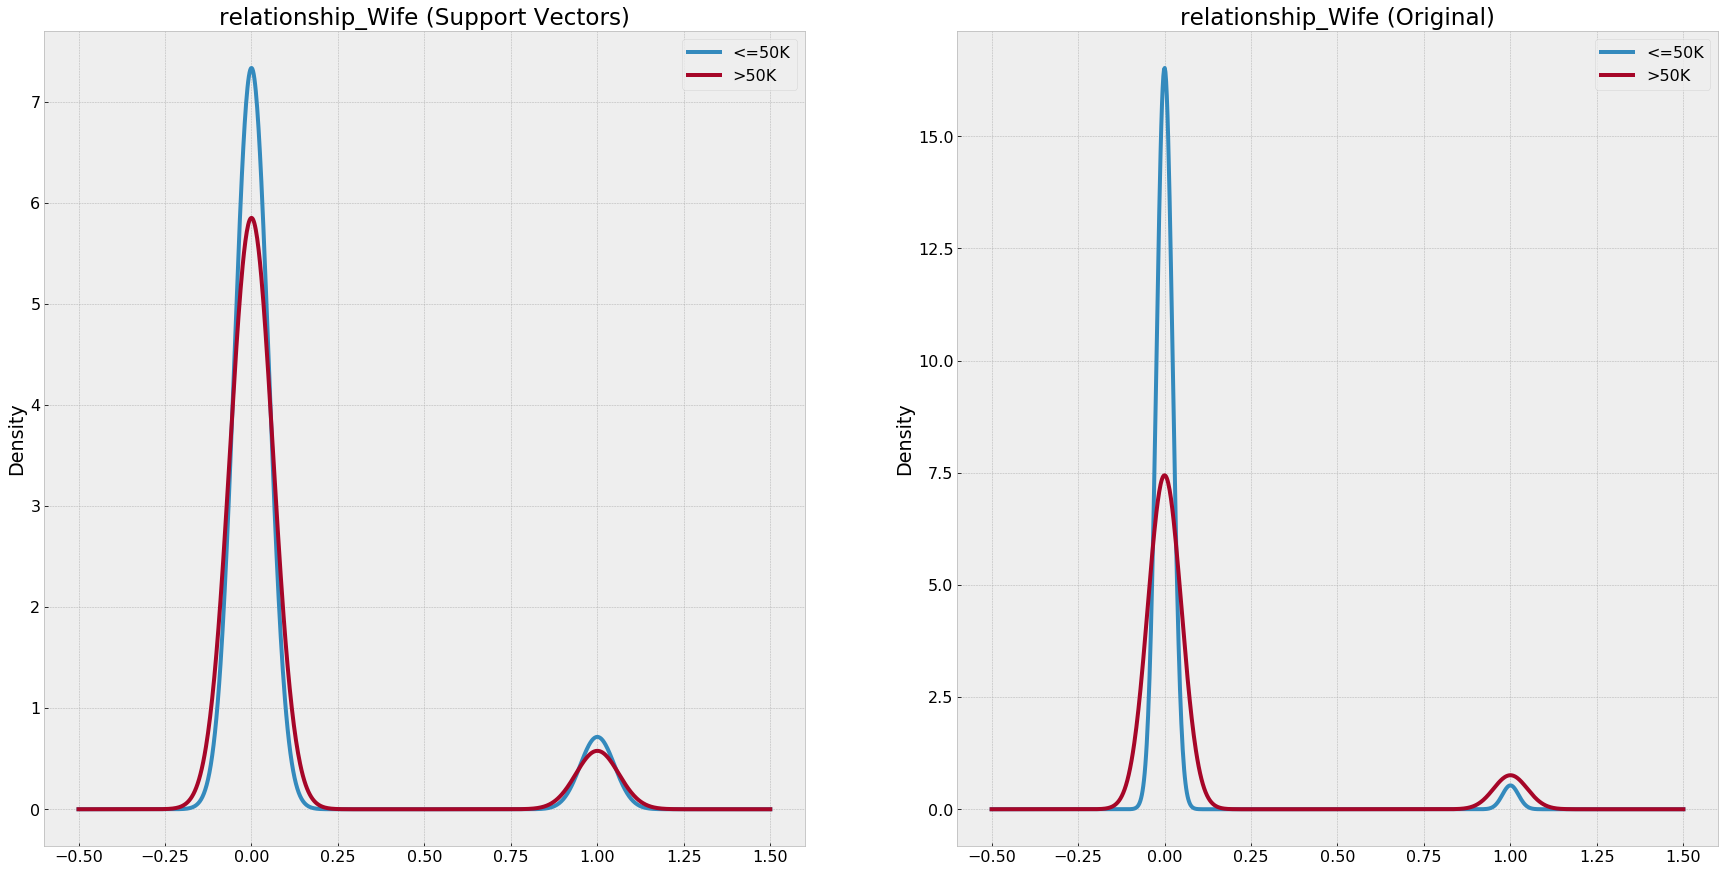

<Figure size 720x288 with 0 Axes>

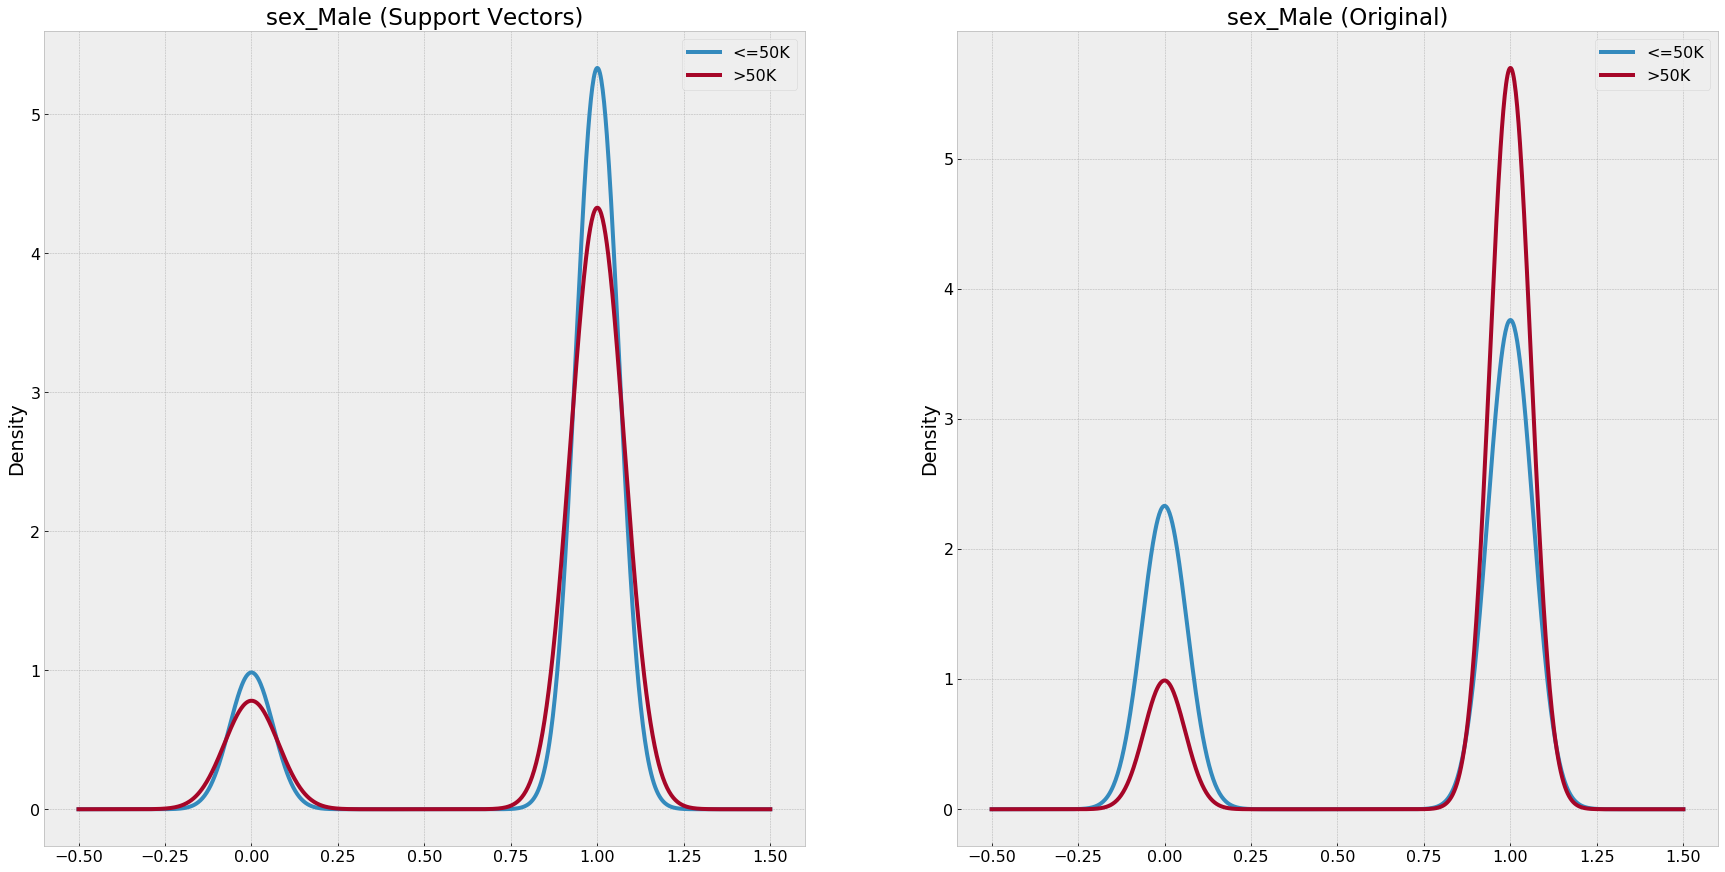

<Figure size 720x288 with 0 Axes>

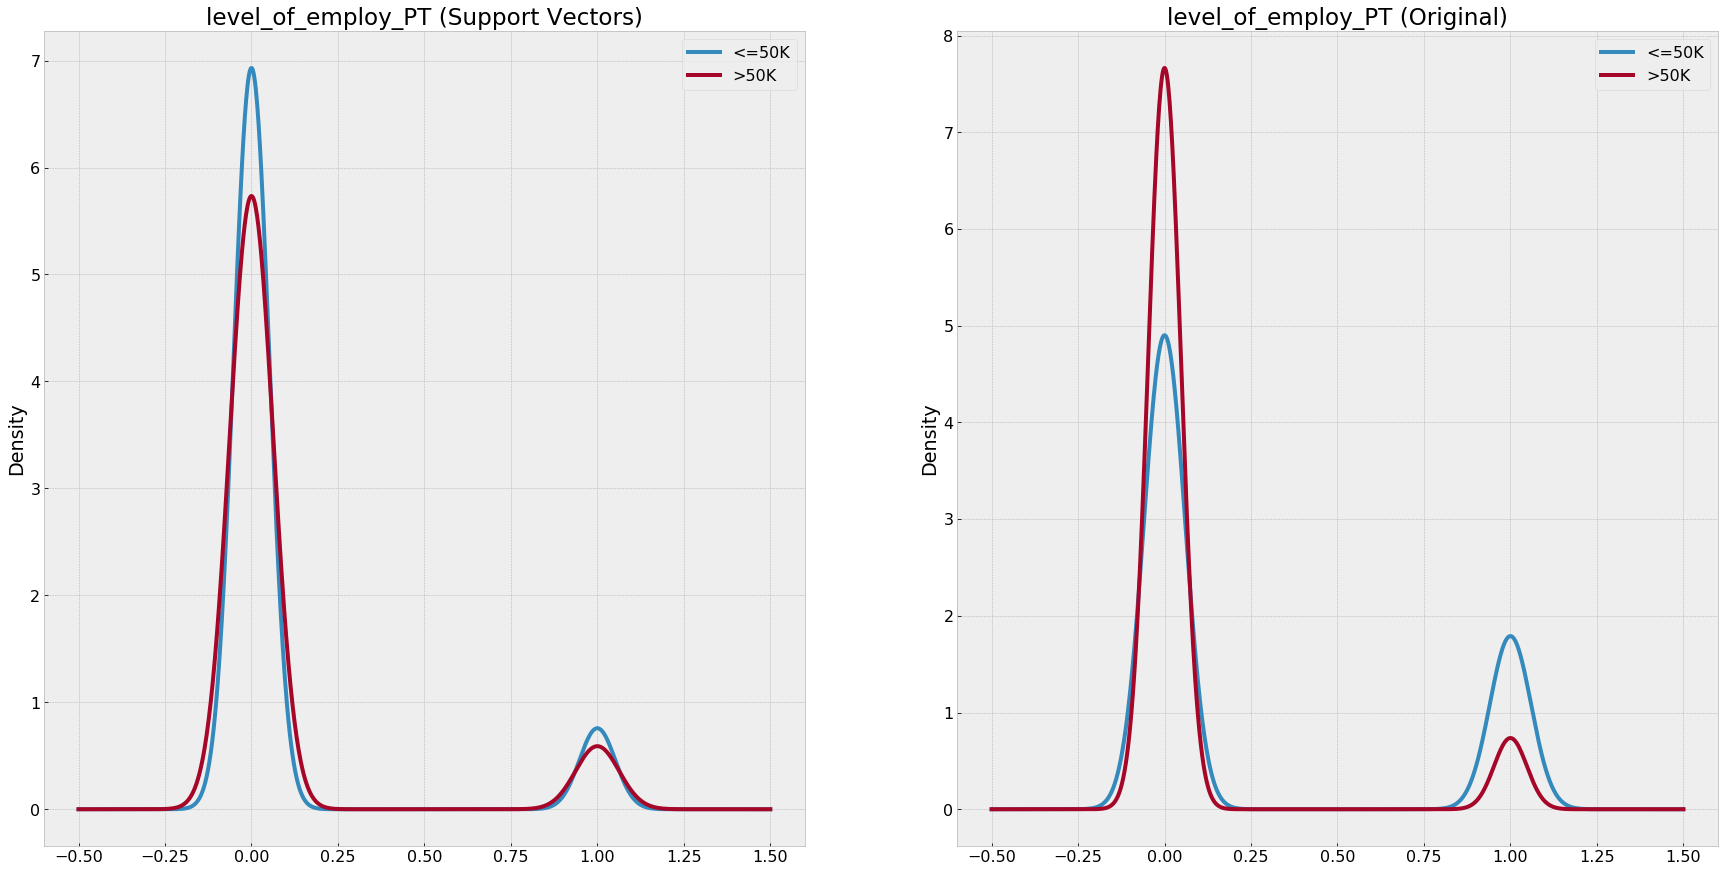

In [53]:
#https://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4



# group the original data and the support vectors
df_grouped_support = df_support.groupby(['income_outcome'])
df_grouped = ml_df.groupby(['income_outcome'])

# plot KDE of Different variables
vars_to_plot = ['education_num_yr', 'cap_gain', 'age', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'level_of_employ_PT']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.figure(figsize=(30,15))
    plt.rcParams.update({'font.size': 16,'lines.linewidth':4})
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')

In [54]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
log_clf = LogisticRegression(penalty='l2', C=0.5, class_weight=None, solver='liblinear')
rfe = RFE(estimator=log_clf, n_features_to_select=10, step=1)
rfe.fit(X_train_scaled, y_train)
ranking = rfe.ranking_
ranks = list(rfe.ranking_)
names_ = list(ml_df.columns)
names_.remove('income_outcome')
ranking_dict = {'Importance_Ranking' : ranks, "Features" : names_}
important_feat_df = pd.DataFrame(ranking_dict)
important_feat_df.sort_values(by = 'Importance_Ranking').head(n=25)

Importance_Ranking                              Features
0                    1                                   age
54                   1                              sex_Male
53                   1                     relationship_Wife
51                   1                relationship_Own-child
42                   1              occupation_Other-service
27                   1                   education_Preschool
8                    1                   education_level_ord
69                   1                marital_stat_Unmarried
3                    1                              cap_gain
5                    1                        hours_per_week
43                   2            occupation_Priv-house-serv
34                   3              marital_status_Separated
39                   4            occupation_Farming-fishing
4                    5                              cap_loss
32                   6  marital_status_Married-spouse-absent
31                   7     marital_status_Married-civ-spouse
68                   8                      age_range_senior
38                   9            occupation_Exec-managerial
33                  10          marital_status_Never-married
28                  11                 education_Prof-school
60                  12                    level_of_employ_PT
40                  13          occupation_Handlers-cleaners
12                  14            workclass_Self-emp-not-inc
14                  15                 workclass_Without-pay
67                  16                       age_range_child

In [55]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
log_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter=1e6 )
rfecv = RFECV(estimator=log_clf, step=1, cv=cv_object, min_features_to_select = 4)
rfecv.fit(X_train_scaled, y_train)
ranking = rfecv.ranking_
ranks = list(rfecv.ranking_)
names_ = list(ml_df.columns)
names_.remove('income_outcome')
ranking_dict = {'Importance_Ranking' : ranks, "Features" : names_}
important_feat_df = pd.DataFrame(ranking_dict)
important_feat_df.sort_values(by = 'Importance_Ranking').head(n=25)



Importance_Ranking                              Features
0                    1                                   age
31                   1     marital_status_Married-civ-spouse
32                   1  marital_status_Married-spouse-absent
33                   1          marital_status_Never-married
68                   1                      age_range_senior
35                   1                marital_status_Widowed
38                   1            occupation_Exec-managerial
39                   1            occupation_Farming-fishing
40                   1          occupation_Handlers-cleaners
41                   1          occupation_Machine-op-inspct
42                   1              occupation_Other-service
43                   1            occupation_Priv-house-serv
28                   1                 education_Prof-school
44                   1             occupation_Prof-specialty
46                   1                      occupation_Sales
47                   1               occupation_Tech-support
51                   1                relationship_Own-child
53                   1                     relationship_Wife
54                   1                              sex_Male
55                   1               race_Asian-Pac-Islander
56                   1                            race_Black
58                   1                            race_White
60                   1                    level_of_employ_PT
64                   1                 education_level_PGRAD
67                   1                       age_range_child

In [56]:
important_feat_df.sort_values(by = 'Importance_Ranking').head(n=70)

Importance_Ranking                              Features
0                    1                                   age
31                   1     marital_status_Married-civ-spouse
32                   1  marital_status_Married-spouse-absent
33                   1          marital_status_Never-married
68                   1                      age_range_senior
..                 ...                                   ...
17                  28                     education_1st-4th
29                  29                education_Some-college
18                  30                     education_5th-6th
16                  31                        education_12th
57                  32                            race_Other

[70 rows x 2 columns]

In [57]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
#https://docs.python.org/3/library/time.html#functions


svm_clf = SVC(C=0.5, kernel='rbf', gamma='auto') 
#svm_clf = SVC(C=10, kernel='rbf', gamma=10) #terrible scores and long compute times

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)): 
    

    ML_std_clf.fit(X[train_indices])
    X_train_scaled = ML_std_clf.transform(X[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X[test_indices]) 
    
    t = time.process_time()

    svm_clf.fit(X_train_scaled, y[train_indices])  

    y_hat = svm_clf.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t

    acc = mt.accuracy_score(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1
    
    

====Iteration 0  ====

Accuracy:  0.8375727348295927 

f1_score: 0.6339452978643686 

precision_score: 0.7224594363791631 

roc_auc_score: 0.7464012972207354 

Confusion Matrix: 

      0    1
0  4192  325
1   652  846 

Train Time:  38.807858255000156 s

====Iteration 1  ====

Accuracy:  0.8408977556109726 

f1_score: 0.6354285714285715 

precision_score: 0.7400177462289264 

roc_auc_score: 0.7459381307760949 

Confusion Matrix: 

      0    1
0  4224  293
1   664  834 

Train Time:  39.348383281999986 s

====Iteration 2  ====

Accuracy:  0.8457190357439734 

f1_score: 0.6482183472327521 

precision_score: 0.75 

roc_auc_score: 0.7538330200728119 

Confusion Matrix: 

      0    1
0  4232  285
1   643  855 

Train Time:  38.744711023000036 s



In [58]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4


regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)): 
    
    
    ML_std_clf.fit(X[train_indices])
    X_train_scaled = ML_std_clf.transform(X[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X[test_indices]) 

    t = time.process_time()
    
    svm_sgd.fit(X_train_scaled,y[train_indices])
    yhat = svm_sgd.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t
    
    acc = mt.accuracy_score(y[test_indices],yhat)
    f1_scor_ = mt.f1_score(y[test_indices],yhat)
    prec_scor_ = mt.precision_score(y[test_indices], yhat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],yhat)
    conf = mt.confusion_matrix(y[test_indices],yhat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1

====Iteration 0  ====

Accuracy:  0.827763923524522 

f1_score: 0.5914826498422714 

precision_score: 0.7225433526011561 

roc_auc_score: 0.7184542122874777 

Confusion Matrix: 

      0    1
0  4229  288
1   748  750 

Train Time:  0.04862769600003958 s

====Iteration 1  ====

Accuracy:  0.8309226932668329 

f1_score: 0.5962683604605002 

precision_score: 0.7355533790401567 

roc_auc_score: 0.7207804635388695 

Confusion Matrix: 

      0    1
0  4247  270
1   747  751 

Train Time:  0.0493816359999073 s

====Iteration 2  ====

Accuracy:  0.8365752285951787 

f1_score: 0.6034691407825736 

precision_score: 0.762487257900102 

roc_auc_score: 0.7238747671236359 

Confusion Matrix: 

      0    1
0  4284  233
1   750  748 

Train Time:  0.04970627299985608 s



In [59]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4


log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)): 
    
    ML_std_clf.fit(X[train_indices])
    X_train_scaled = ML_std_clf.transform(X[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X[test_indices]) 
    
    t = time.process_time()

    log_sgd.fit(X_train_scaled,y[train_indices])
    yhat = log_sgd.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t
    
    acc = mt.accuracy_score(y[test_indices],yhat)
    f1_scor_ = mt.f1_score(y[test_indices],yhat)
    prec_scor_ = mt.precision_score(y[test_indices], yhat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],yhat)
    conf = mt.confusion_matrix(y[test_indices],yhat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1

====Iteration 0  ====

Accuracy:  0.828428927680798 

f1_score: 0.5831987075928917 

precision_score: 0.7382413087934561 

roc_auc_score: 0.7126505919042525 

Confusion Matrix: 

      0    1
0  4261  256
1   776  722 

Train Time:  0.07229222299997673 s

====Iteration 1  ====

Accuracy:  0.8299251870324189 

f1_score: 0.5863323898099474 

precision_score: 0.7435897435897436 

roc_auc_score: 0.7143160846444806 

Confusion Matrix: 

      0    1
0  4267  250
1   773  725 

Train Time:  0.07296606899990365 s

====Iteration 2  ====

Accuracy:  0.8367414796342477 

f1_score: 0.5945499587118084 

precision_score: 0.7792207792207793 

roc_auc_score: 0.717739067927039 

Confusion Matrix: 

      0    1
0  4313  204
1   778  720 

Train Time:  0.07605037799999081 s



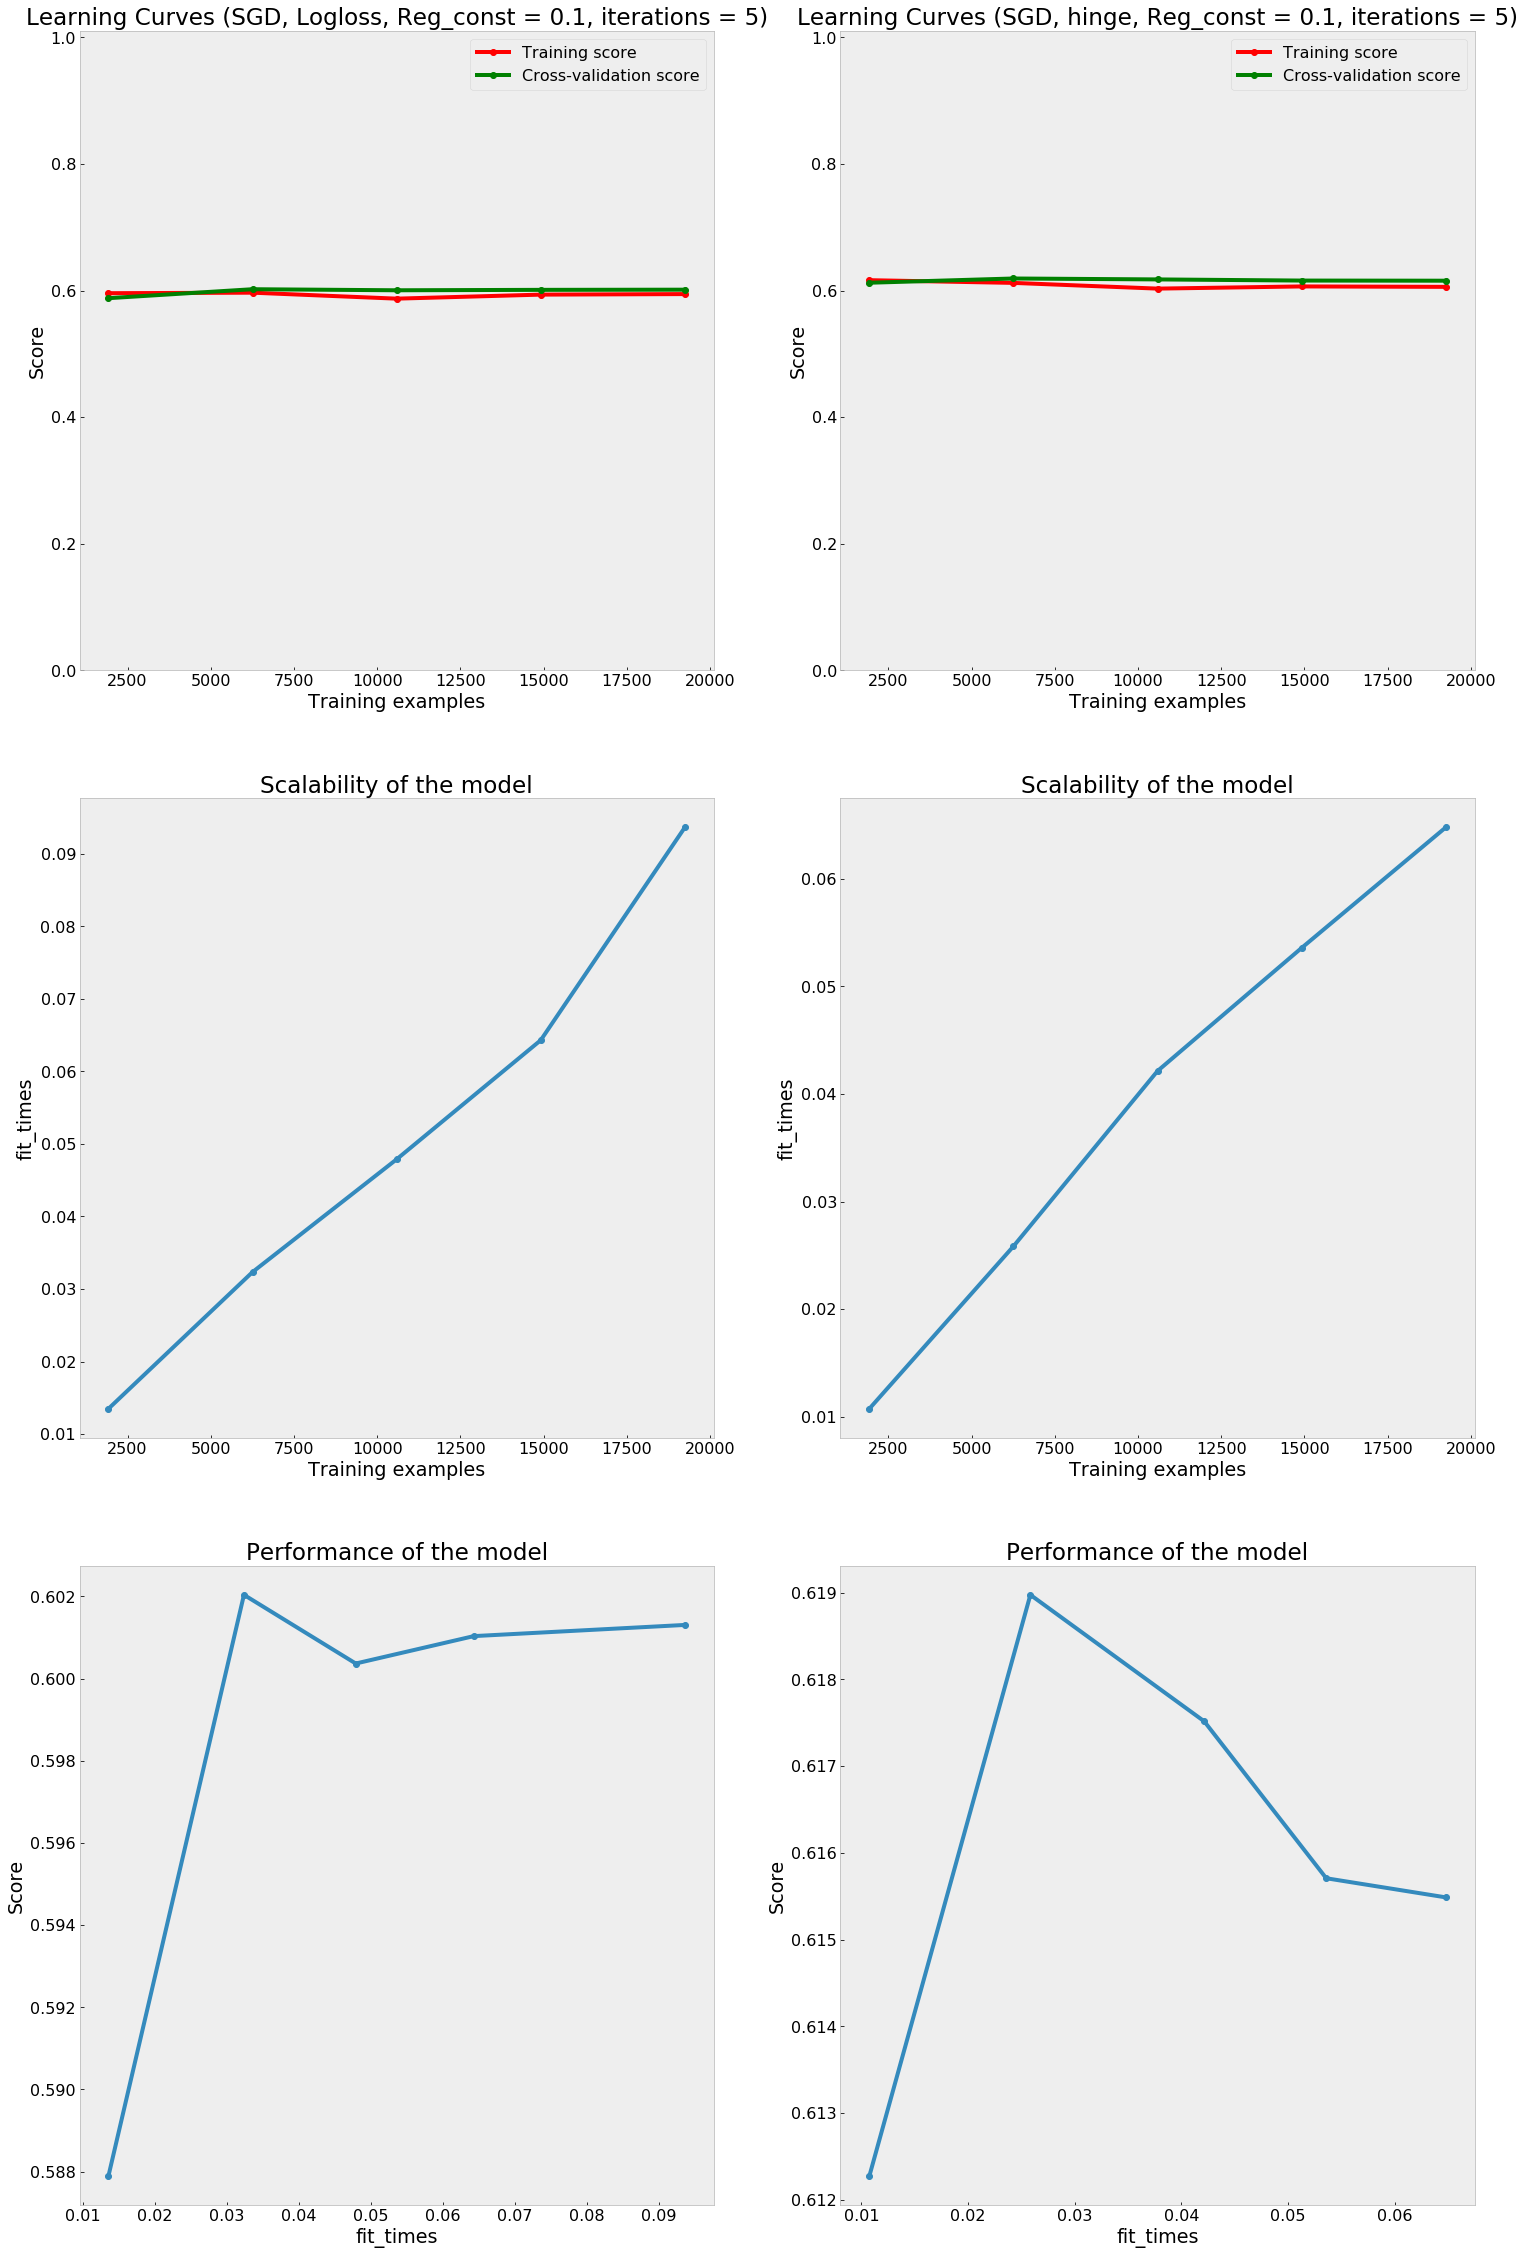

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(25, 40))

title = r"Learning Curves (SGD, Logloss, Reg_const = 0.1, iterations = 5)"
# SVC is more expensive so we do a lower number of CV iterations:

regularize_const = 0.1
iterations = 5
estimator = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

plot_learning_curve(estimator, title, X_train_scaled, y_train, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')


title = r"Learning Curves (SGD, hinge, Reg_const = 0.1, iterations = 5)"


regularize_const = 0.1
iterations = 5
estimator = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

plot_learning_curve(estimator, title, X_train_scaled, y_train, axes=axes[:, 1], ylim=(0.0, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')

plt.show()

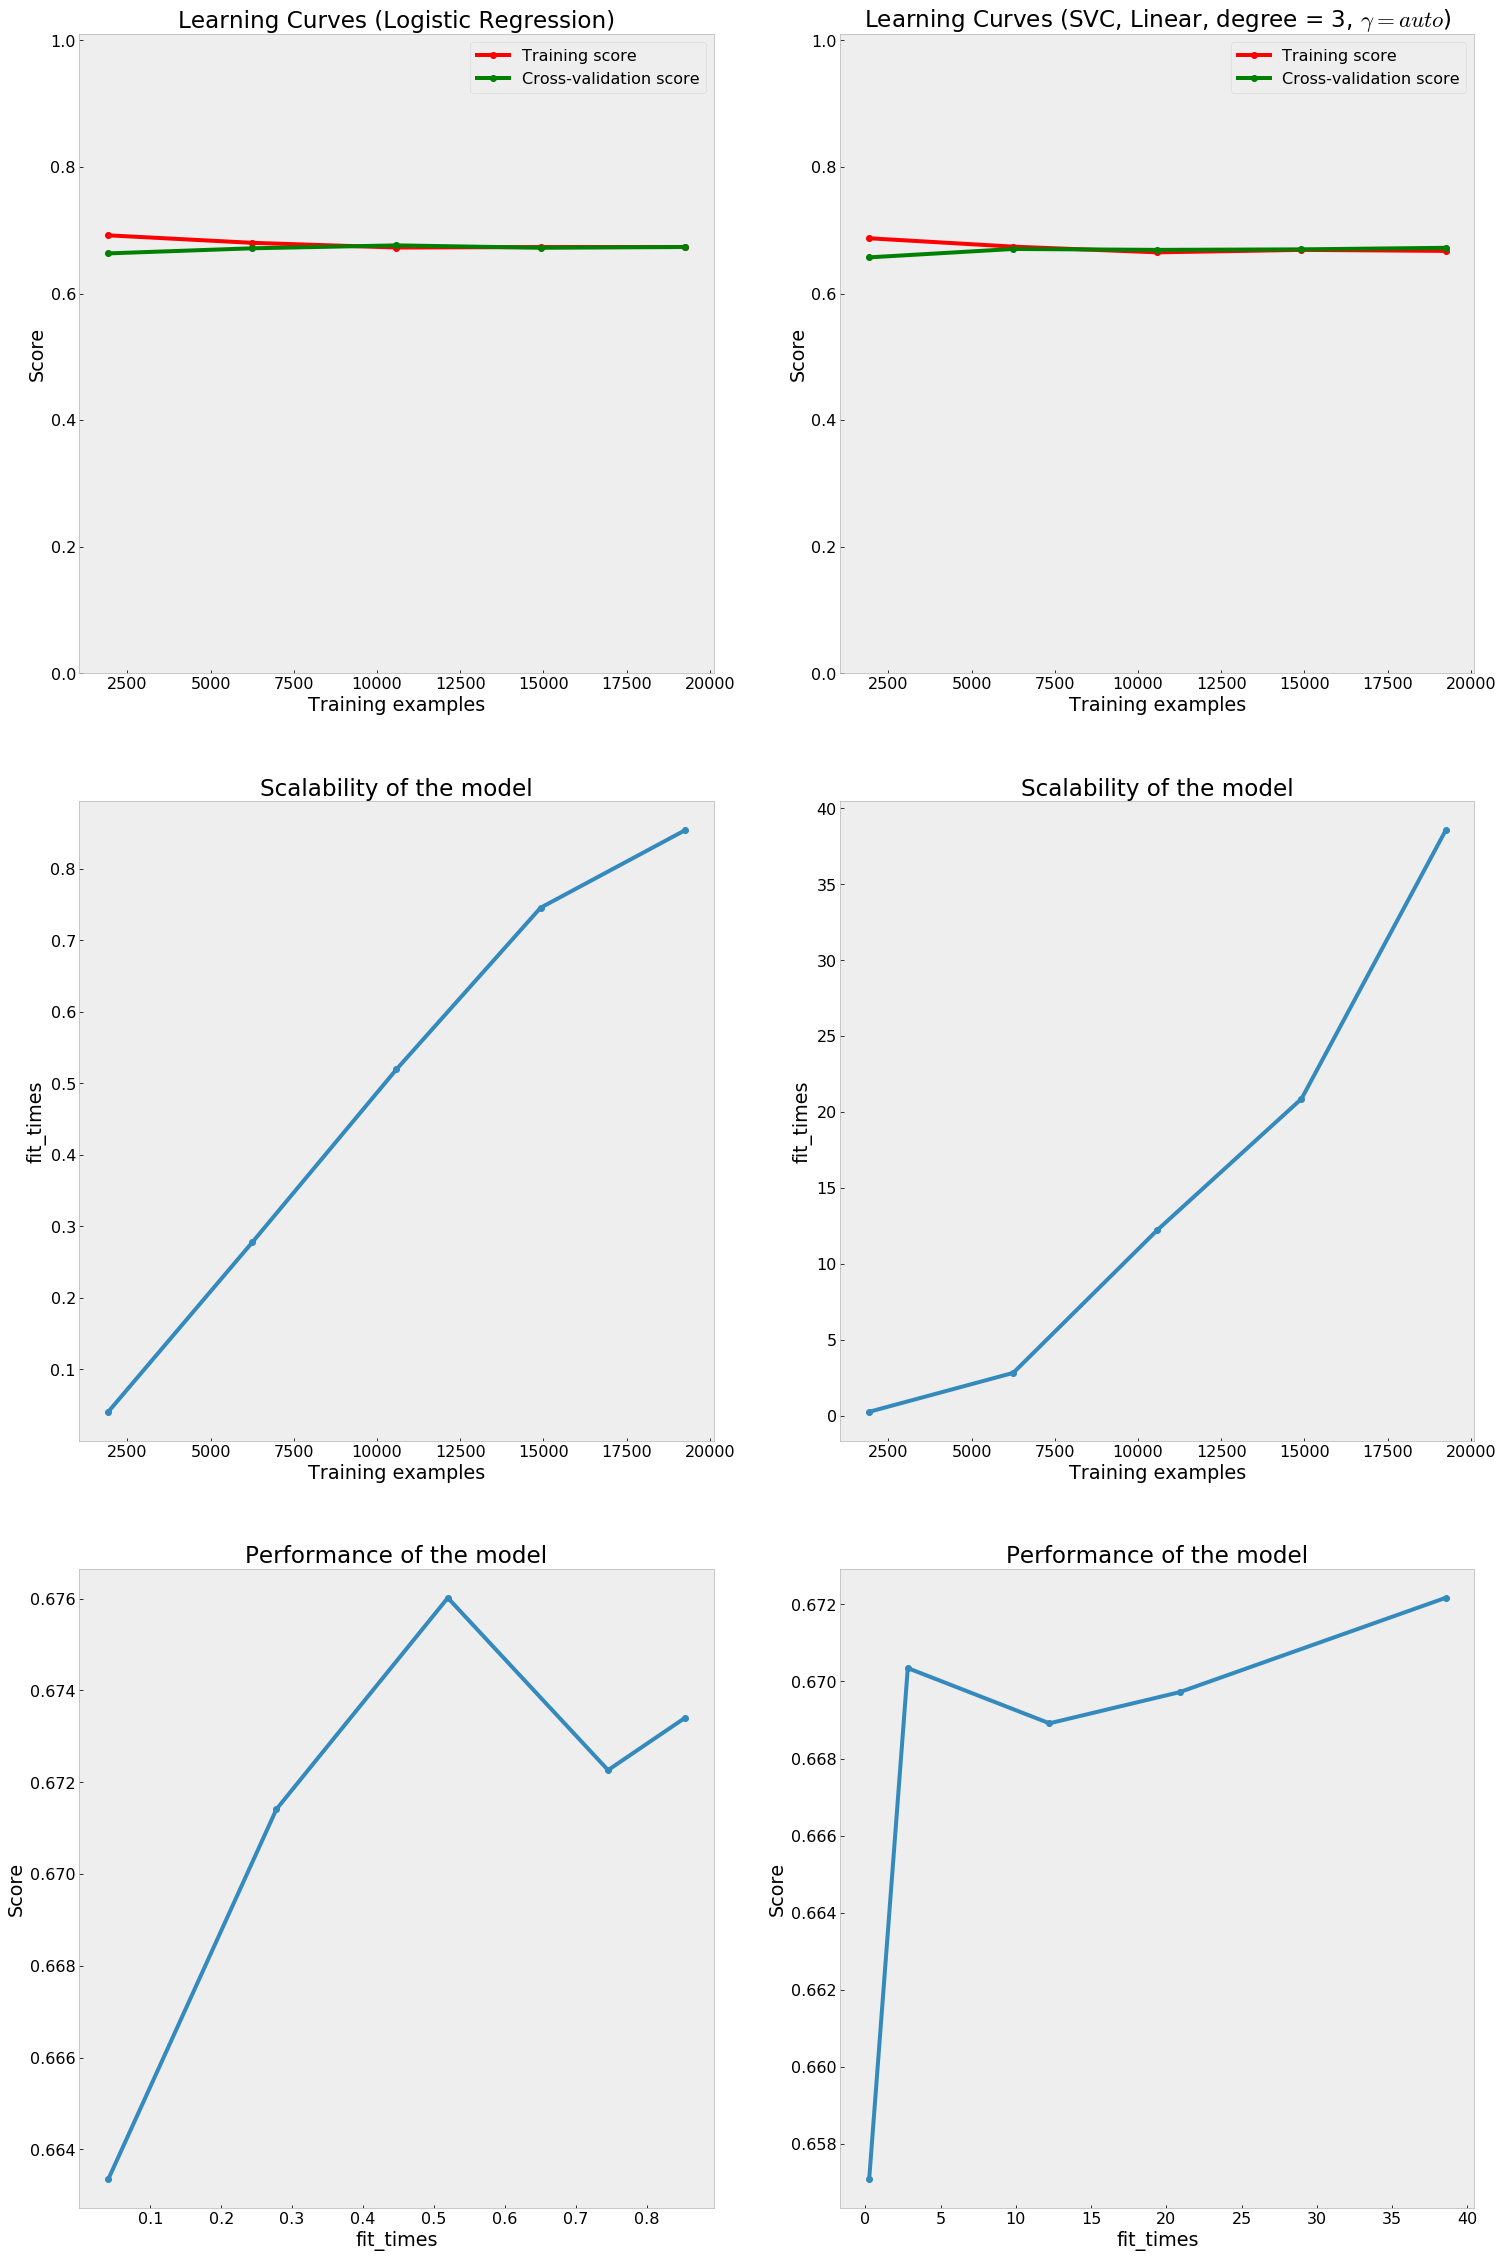

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(25, 40))

title = r"Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:

estimator = LogisticRegression(penalty='l2', C=0.5, class_weight=None, solver='liblinear')

plot_learning_curve(estimator, title, X_train_scaled, y_train, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')


title = r"Learning Curves (SVC, Linear, degree = 3, $\gamma=auto$)"


estimator = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')

plot_learning_curve(estimator, title, X_train_scaled, y_train, axes=axes[:, 1], ylim=(0.0, 1.01),
                    cv=cv_object, n_jobs=4, scoring = 'f1')

plt.show()

Rubric Sections

https://www.datasciencecentral.com/profiles/blogs/crisp-dm-a-standard-methodology-to-ensure-a-good-outcome

Create Models: 

50 PTS 

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

Model Advantages: 

10 PTS 

Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Interpret Feature Importance: 

30 PTS 

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

Interpret Support Vectors: 

10 PTS 

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.